In [1]:
import sys
sys.path.append(".")
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.config import ACTIVITIES, ABBR, TZ_PARIS, TZ_LONDON
from src.viz_style import apply_nature_style

apply_nature_style()

In [3]:
from src.utils_time import to_local_time_series, split_cross_midnight, week_start_monday
from src.utils_split import split_users_by_hash
from src.regularity import regularity_report, summarize_reg, compute_user_hex_stats, infer_home_work_anchors, make_hex_lookup

In [4]:
from pathlib import Path
import joblib

ROOT = Path(".")
OUT_DATA = ROOT / "outputs" / "data"
OUT_TAB  = ROOT / "outputs" / "tables"
OUT_FIG  = ROOT / "outputs" / "figures"
OUT_MODELS = ROOT / "outputs" / "models"
OUT_TAB.mkdir(parents=True, exist_ok=True)
OUT_FIG.mkdir(parents=True, exist_ok=True)

def prep_stays(path):
    d = pd.read_parquet(path)
    if "user_id" not in d.columns and "userid" in d.columns:
        d = d.rename(columns={"userid":"user_id"})
    d["user_id"] = d["user_id"].astype(str)
    d["start_time"] = pd.to_datetime(d["start_time"], errors="coerce")
    d["end_time"] = pd.to_datetime(d["end_time"], errors="coerce")
    if "duration_min" not in d.columns:
        d["duration_min"] = (d["end_time"] - d["start_time"]).dt.total_seconds()/60.0
    d["duration_min"] = pd.to_numeric(d["duration_min"], errors="coerce")
    d["hex_id"] = d["hex_id"].astype(str).replace({"": np.nan, "nan": np.nan})
    d = d.dropna(subset=["user_id","start_time","end_time","duration_min","hex_id"]).copy()
    d = d[d["duration_min"] > 0].copy()
    return d

uk_1w_path = sorted(OUT_DATA.glob("uk_london_stays_1w_u*.parquet"))[-1]
uk_1m_path = sorted(OUT_DATA.glob("uk_london_stays_1m_u*.parquet"))[-1]
uk_3m_path = sorted(OUT_DATA.glob("uk_london_stays_3m_u*.parquet"))[-1]

uk_1w = prep_stays(uk_1w_path)
uk_1m = prep_stays(uk_1m_path)
uk_3m = prep_stays(uk_3m_path)

# UK Huff POI (from notebook 03)
uk_poi_huff_path = sorted(OUT_DATA.glob("uk_poi_huff_k4_b1.5_u*.parquet"))[-1]
uk_poi = pd.read_parquet(uk_poi_huff_path)
uk_poi["hex_id"] = uk_poi["hex_id"].astype(str)

POI_COLS = ["poi_edu_cnt","poi_health_cnt","poi_retail_cnt","poi_leisure_cnt",
            "poi_transport_cnt","poi_accom_cnt","poi_office_cnt","poi_total_cnt"]
for c in POI_COLS:
    if c not in uk_poi.columns:
        uk_poi[c] = 0

# Paris GBDT
gbdt = joblib.load(OUT_MODELS / "paris_gbdt_baseline.joblib")
print("Loaded GBDT:", type(gbdt))

print("UK stays:", len(uk_1w), len(uk_1m), len(uk_3m), "users(3M):", uk_3m["user_id"].nunique())
print("UK Huff POI rows:", len(uk_poi))

Loaded GBDT: <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier'>
UK stays: 5946 24782 61523 users(3M): 231
UK Huff POI rows: 9392


In [5]:
def infer_anchors_and_home_area(stays_df, k_home_area=3):
    d = stays_df.copy().sort_values(["user_id","start_time"])
    d["date"] = d["start_time"].dt.date

    mid = d["start_time"] + pd.to_timedelta(d["duration_min"]/2, unit="m")
    hh = mid.dt.hour + mid.dt.minute/60.0
    night = (hh >= 20) | (hh < 6)
    weekday = (d["start_time"].dt.weekday < 5)
    workhour = weekday & (hh >= 9) & (hh < 17)

    d["night_dwell"] = np.where(night, d["duration_min"], 0.0)
    d["work_dwell"]  = np.where(workhour, d["duration_min"], 0.0)

    g = d.groupby(["user_id","hex_id"], as_index=False).agg(
        night_dwell=("night_dwell","sum"),
        work_dwell=("work_dwell","sum"),
        visit_days=("date", lambda x: x.nunique()),
        dwell=("duration_min","sum"),
    )

    home_hex = g.sort_values(["user_id","night_dwell"], ascending=[True,False]) \
                .drop_duplicates("user_id")[["user_id","hex_id"]].rename(columns={"hex_id":"home_hex"})
    work_hex = g.merge(home_hex, on="user_id", how="left")
    work_hex = work_hex[work_hex["hex_id"] != work_hex["home_hex"]]
    work_hex = work_hex.sort_values(["user_id","work_dwell"], ascending=[True,False]) \
                       .drop_duplicates("user_id")[["user_id","hex_id"]].rename(columns={"hex_id":"work_hex"})

    home_area = g[g["night_dwell"] > 0].sort_values(["user_id","night_dwell"], ascending=[True,False]) \
                  .groupby("user_id").head(k_home_area)
    home_area_lookup = home_area.groupby("user_id")["hex_id"].apply(lambda x: set(x.astype(str))).to_dict()

    anchors = home_hex.merge(work_hex, on="user_id", how="left")
    anchors["home_hex"] = anchors["home_hex"].astype(str)
    anchors["work_hex"] = anchors["work_hex"].astype(str)
    return anchors, home_area_lookup

anchors_uk, home_area_uk = infer_anchors_and_home_area(uk_3m, k_home_area=3)
home_uk = dict(zip(anchors_uk["user_id"], anchors_uk["home_hex"]))
work_uk = dict(zip(anchors_uk["user_id"], anchors_uk["work_hex"]))

print("Anchors users:", len(home_uk))

Anchors users: 231


### found multi home location issue, update home location inference after 09_manual_check

In [123]:
def build_primary_home_cluster_from_night(stays_df, k_candidates=10, dist_km=.5):
    d = stays_df.copy().sort_values(["user_id","start_time"])
    mid = d["start_time"] + pd.to_timedelta(d["duration_min"]/2, unit="m")
    hh = mid.dt.hour + mid.dt.minute/60.0
    night = (hh >= 20) | (hh < 6)
    d = d[night].copy()

    g = d.groupby(["user_id","hex_id"], as_index=False)["duration_min"].sum().rename(columns={"duration_min":"night_dwell"})

    home_primary = {}
    for u, gu in g.groupby("user_id", sort=False):
        gu = gu.sort_values("night_dwell", ascending=False).head(k_candidates)
        hexes = gu["hex_id"].astype(str).tolist()
        w = gu.set_index("hex_id")["night_dwell"].to_dict()

        # adjacency by distance <= dist_km
        adj = {h:set() for h in hexes}
        for i,h1 in enumerate(hexes):
            lat1, lon1 = centroids.get(h1, (np.nan,np.nan))
            if not np.isfinite(lat1): 
                continue
            for j in range(i+1, len(hexes)):
                h2 = hexes[j]
                lat2, lon2 = centroids.get(h2, (np.nan,np.nan))
                if not np.isfinite(lat2):
                    continue
                if haversine_km(lat1, lon1, lat2, lon2) <= dist_km:
                    adj[h1].add(h2); adj[h2].add(h1)

        # connected components
        seen=set(); comps=[]
        for h in hexes:
            if h in seen: 
                continue
            stack=[h]; comp=set()
            while stack:
                x=stack.pop()
                if x in seen: 
                    continue
                seen.add(x); comp.add(x)
                stack.extend(list(adj[x]-seen))
            comps.append(comp)

        # choose largest by night_dwell sum
        if comps:
            comps = sorted(comps, key=lambda c: sum(w.get(h,0.0) for h in c), reverse=True)
            home_primary[u] = comps[0]
        else:
            home_primary[u] = set()

    return home_primary

home_primary_uk = build_primary_home_cluster_from_night(uk_3m, k_candidates=10, dist_km=.5)
print("Primary home cluster built. Example sizes:",
      pd.Series([len(v) for v in home_primary_uk.values()]).describe())

Primary home cluster built. Example sizes: count    231.000000
mean       1.471861
std        0.907857
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        8.000000
dtype: float64


In [177]:
def expand_home_cluster(home_primary, k=1):
    out = {}
    for u, hs in home_primary.items():
        ex = set()
        for h in hs:
            ex |= set(h3.grid_disk(h, k)) if hasattr(h3, "grid_disk") else set(h3.k_ring(h, k))
        out[u] = set(map(str, ex))
    return out

home_primary_uk_exp = expand_home_cluster(home_primary_uk, k=1)

In [124]:
import h3, math, numpy as np

def cell_to_latlon(cell):
    if hasattr(h3, "cell_to_latlng"):
        lat, lon = h3.cell_to_latlng(cell)
    else:
        lat, lon = h3.h3_to_geo(cell)
    return float(lat), float(lon)

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2-lat1)
    dlmb = math.radians(lon2-lon1)
    a = math.sin(dphi/2)**2 + math.cos(p1)*math.cos(p2)*math.sin(dlmb/2)**2
    return 2*R*math.asin(math.sqrt(a))

# centroids over UK 3M hex (covers 1W/1M)
all_hex = pd.Index(uk_3m["hex_id"].astype(str).unique())
centroids = {h: cell_to_latlon(h) for h in all_hex}
print("UK centroids:", len(centroids))

UK centroids: 9392


In [125]:
def add_poi_features(df, poi_df):
    d = df.merge(poi_df[["hex_id"]+POI_COLS], on="hex_id", how="left").fillna(0)
    sem = d["poi_edu_cnt"] + d["poi_health_cnt"] + d["poi_retail_cnt"] + d["poi_leisure_cnt"]
    d["sem_total"] = sem
    d["edu_ratio"] = d["poi_edu_cnt"]/(sem+1.0)
    d["health_ratio"] = d["poi_health_cnt"]/(sem+1.0)
    d["retail_ratio"] = d["poi_retail_cnt"]/(sem+1.0)
    d["leisure_ratio"] = d["poi_leisure_cnt"]/(sem+1.0)
    return d

def add_time_duration_features(df):
    d = df.copy()
    st = d["start_time"]
    d["hour"] = st.dt.hour
    d["dow"] = st.dt.weekday
    d["is_weekday"] = (d["dow"] < 5).astype(int)
    d["log_dur"] = np.log1p(d["duration_min"].astype(float))
    return d

def add_distance_features(df, home_lookup, work_lookup, home_area_lookup):
    d = df.copy()
    ll = d["hex_id"].map(lambda h: centroids.get(str(h), (np.nan, np.nan)))
    d["lat"] = [x[0] for x in ll]
    d["lon"] = [x[1] for x in ll]

    def anchor_ll(u, mp):
        hh = mp.get(u, None)
        return centroids.get(str(hh), (np.nan, np.nan))

    home_ll = d["user_id"].map(lambda u: anchor_ll(u, home_lookup))
    work_ll = d["user_id"].map(lambda u: anchor_ll(u, work_lookup))
    d["home_lat"] = [x[0] for x in home_ll]; d["home_lon"] = [x[1] for x in home_ll]
    d["work_lat"] = [x[0] for x in work_ll]; d["work_lon"] = [x[1] for x in work_ll]

    d["dist_to_home_km"] = [
        haversine_km(a,b,c,e) if np.isfinite(a) and np.isfinite(c) else np.nan
        for a,b,c,e in zip(d["lat"], d["lon"], d["home_lat"], d["home_lon"])
    ]
    d["dist_to_work_km"] = [
        haversine_km(a,b,c,e) if np.isfinite(a) and np.isfinite(c) else np.nan
        for a,b,c,e in zip(d["lat"], d["lon"], d["work_lat"], d["work_lon"])
    ]

    def dist_to_home_area_min(u, lat, lon):
        hs = home_area_lookup.get(u, None)
        if not hs:
            return np.nan
        best = np.inf
        for hh in hs:
            ll = centroids.get(str(hh))
            if ll is None: 
                continue
            best = min(best, haversine_km(lat, lon, ll[0], ll[1]))
        return best if np.isfinite(best) else np.nan

    d["dist_to_home_area_min_km"] = [
        dist_to_home_area_min(u, la, lo) if np.isfinite(la) else np.nan
        for u, la, lo in zip(d["user_id"], d["lat"], d["lon"])
    ]

    d["near_home_0p5km"] = (d["dist_to_home_km"] <= 0.5).astype(int)
    d["near_work_0p5km"] = (d["dist_to_work_km"] <= 0.5).astype(int)
    return d

def add_prev_distance(df):
    d = df.sort_values(["user_id","start_time"]).copy()
    prev_hex = d.groupby("user_id")["hex_id"].shift(1)
    prev_ll = prev_hex.map(lambda h: centroids.get(str(h), (np.nan, np.nan)))
    prev_lat = [x[0] for x in prev_ll]; prev_lon = [x[1] for x in prev_ll]
    d["dist_prev_km"] = [
        haversine_km(la, lo, pla, plo) if np.isfinite(la) and np.isfinite(pla) else np.nan
        for la,lo,pla,plo in zip(d["lat"], d["lon"], prev_lat, prev_lon)
    ]
    return d

FEATURES = [
    "hour","dow","is_weekday","duration_min","log_dur",
    "poi_edu_cnt","poi_health_cnt","poi_retail_cnt","poi_leisure_cnt","poi_total_cnt",
    "edu_ratio","health_ratio","retail_ratio","leisure_ratio",
    "dist_to_home_km","dist_to_work_km","dist_to_home_area_min_km","near_home_0p5km","near_work_0p5km",
    "dist_prev_km",
]

def build_features_uk(stays):
    d = stays.copy()
    d = add_time_duration_features(d)
    d = add_poi_features(d, uk_poi)
    d = add_distance_features(d, home_uk, work_uk, home_area_uk)
    d = add_prev_distance(d)
    return d

In [126]:
def get_proba_aligned(model, X, labels=ACTIVITIES):
    proba = model.predict_proba(X)
    classes = list(model.classes_)
    idx = [classes.index(a) for a in labels]
    return proba[:, idx]

X_1w_df = build_features_uk(uk_1w)
X_1m_df = build_features_uk(uk_1m)
X_3m_df = build_features_uk(uk_3m)

X1 = X_1w_df[FEATURES].replace([np.inf,-np.inf], np.nan)
X2 = X_1m_df[FEATURES].replace([np.inf,-np.inf], np.nan)
X3 = X_3m_df[FEATURES].replace([np.inf,-np.inf], np.nan)

proba_1w = get_proba_aligned(gbdt, X1, ACTIVITIES)
proba_1m = get_proba_aligned(gbdt, X2, ACTIVITIES)
proba_3m = get_proba_aligned(gbdt, X3, ACTIVITIES)

print("Proba shapes:", proba_1w.shape, proba_3m.shape)

Proba shapes: (5946, 7) (61523, 7)


In [127]:
TIME_BINS = [(0,360),(360,600),(600,960),(960,1200),(1200,1440)]
def time_bin_id(minute):
    for i,(a,b) in enumerate(TIME_BINS):
        if a <= minute < b: return i
    return -1

act2i = {a:i for i,a in enumerate(ACTIVITIES)}
i2act = {i:a for a,i in act2i.items()}
K = len(ACTIVITIES)

def split_by_gap(df_u, break_gap_hours=8):
    thr = break_gap_hours * 3600.0
    g = df_u.sort_values("start_time")
    if len(g)==0: return []
    idxs = list(g.index)
    parts=[]; cur=[idxs[0]]
    for a,b in zip(idxs[:-1], idxs[1:]):
        gap = (g.loc[b,"start_time"] - g.loc[a,"end_time"]).total_seconds()
        if gap > thr:
            parts.append(g.loc[cur].copy()); cur=[b]
        else:
            cur.append(b)
    parts.append(g.loc[cur].copy())
    return parts

# update split, ref 02_uk_extract_stays last few results
def split_by_day_or_gap(g, tz="Europe/London", gap_hours=8, max_len=200, assume_utc_if_naive=True):
    d = g.sort_values("start_time").copy()
    d["start_time"] = to_local_time_series(d["start_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)
    d["end_time"]   = to_local_time_series(d["end_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)

    thr = gap_hours * 3600.0
    idxs = list(d.index)
    if not idxs:
        return []

    parts, cur = [], [idxs[0]]
    for a, b in zip(idxs[:-1], idxs[1:]):
        gap = (d.loc[b, "start_time"] - d.loc[a, "end_time"]).total_seconds()
        cross_midnight = d.loc[a, "start_time"].date() != d.loc[b, "start_time"].date()
        too_long = (len(cur) >= max_len)

        if cross_midnight or gap > thr or too_long:
            parts.append(d.loc[cur].copy())
            cur = [b]
        else:
            cur.append(b)

    parts.append(d.loc[cur].copy())
    return parts

def build_A_dict_from_pred(df_feat, proba, alpha=1.0, rho=0.3, break_gap_hours=8, margin_th=0.20):
    df = df_feat.sort_values(["user_id","start_time"]).copy()
    df["proba_row"] = list(proba)

    C_global = np.zeros((K,K), float)
    C_bucket = {}

    def ctx(dt):
        w = int(dt.weekday() >= 5)
        tb = time_bin_id(int(dt.hour*60 + dt.minute))
        return (w, tb)

    def top1_margin(p):
        idx = np.argsort(-p)
        return int(idx[0]), float(p[idx[0]] - p[idx[1]])

    for u, g in df.groupby("user_id", sort=False):
        
        parts = split_by_gap(g, break_gap_hours=8)
        for seq in parts:
            for t in range(len(seq)-1):
                p = np.array(seq.iloc[t]["proba_row"], dtype=float)
                q = np.array(seq.iloc[t+1]["proba_row"], dtype=float)
                a, ma = top1_margin(p)
                b, mb = top1_margin(q)
                if ma < margin_th or mb < margin_th:
                    continue

                dt = seq.iloc[t]["start_time"]
                w, tb = ctx(dt)
                if tb < 0:
                    continue
                if (w,tb) not in C_bucket:
                    C_bucket[(w,tb)] = np.zeros((K,K), float)
                C_bucket[(w,tb)][a,b] += 1.0
                C_global[a,b] += 1.0

    def row_norm(C):
        A = C + alpha
        A = A / A.sum(axis=1, keepdims=True)
        return A

    A_global = row_norm(C_global)
    A_dict = {}
    for w in [0,1]:
        for tb in range(len(TIME_BINS)):
            C = C_bucket.get((w,tb))
            if C is None:
                A_dict[(w,tb)] = A_global.copy()
            else:
                A = row_norm(C)
                A = (1-rho)*A + rho*A_global
                A = A / A.sum(axis=1, keepdims=True)
                A_dict[(w,tb)] = A
    return A_dict

A_dict_uk = build_A_dict_from_pred(X_3m_df, proba_3m, alpha=1.0, rho=0.3, break_gap_hours=8, margin_th=0.20)

def A_getter(seq, t):
    dt = seq.iloc[t]["start_time"]
    w = int(dt.weekday() >= 5)
    tb = time_bin_id(int(dt.hour*60 + dt.minute))
    return A_dict_uk[(w,tb)]

In [178]:
T_TEMP = 0.5
SELF_LOOP = 0.1

P_HOME_OUTSIDE = 2.5
P_HOME_SHORT_OUTSIDE = 1.5
HOME_SHORT_MIN = 60.0
AWAY_NIGHT_MIN = 240.0   # 4h: outside primary home at night -> likely travel/away

def viterbi_decode(logB, seq, self_loop_bonus=0.1):
    eps = 1e-12
    Tlen, K0 = logB.shape
    log_pi = np.log(np.full(K0, 1.0/K0))
    dp = np.full((Tlen,K0), -np.inf)
    bp = np.zeros((Tlen,K0), dtype=int)
    dp[0] = log_pi + logB[0]

    for t in range(1, Tlen):
        A = A_getter(seq, t-1)
        logA = np.log(A + eps)
        for j in range(K0):
            scores = dp[t-1] + logA[:,j] + self_loop_bonus*(np.arange(K0)==j)
            i_star = int(np.argmax(scores))
            bp[t,j] = i_star
            dp[t,j] = scores[i_star] + logB[t,j]

    last = int(np.argmax(dp[Tlen-1]))
    path = [last]
    for t in range(Tlen-1,0,-1):
        last = bp[t,last]
        path.append(last)
    return np.array(path[::-1], dtype=int)

def add_home_constraint(logB, seq, u):
    """
    Use primary home cluster only.
    - Outside primary home: penalize HOME strongly
    - Extra penalty for short or non-night HOME outside (likely mispred)
    - Also treat long night stays outside as "away night": still penalize HOME (push to OTHER)
    """
    home_set = home_primary_uk_exp.get(u, set())

    for t in range(len(seq)):
        h = str(seq.iloc[t]["hex_id"])
        dur = float(seq.iloc[t]["duration_min"])
        st = seq.iloc[t]["start_time"]

        mid = st + pd.to_timedelta(dur/2, unit="m")
        hh = mid.hour + mid.minute/60.0
        is_night = (hh >= 20) or (hh < 6)

        HOME_MASK_VAL = 1e6  # large negative

        if h not in home_set:
            if is_night and dur < 60:   # <2h
                logB[t, act2i["HOME"]] -= HOME_MASK_VAL
            else:
                logB[t, act2i["HOME"]] -= P_HOME_OUTSIDE

            # stronger penalty for short / non-night (likely wrong HOME)
            if (not is_night) or (dur < HOME_SHORT_MIN):
                logB[t, act2i["HOME"]] -= P_HOME_SHORT_OUTSIDE

            # if it's a long night stay outside primary home, treat as "away night"
            # still discourage HOME to avoid multi-home; OTHER will absorb it
            if is_night and dur >= AWAY_NIGHT_MIN:
                logB[t, act2i["HOME"]] -= 0.5 * P_HOME_OUTSIDE

    return logB

def hybrid_decode_stage3(df_feat, proba, T=0.5, self_loop_bonus=0.1):
    df = df_feat.sort_values(["user_id","start_time"]).copy()
    df["proba_row"] = list(proba)
    df["y_pred_s3"] = None

    for u, g in df.groupby("user_id", sort=False):
        parts = split_by_gap(g, break_gap_hours=8)
        for seq in parts:
            P = np.stack(seq["proba_row"].values, axis=0)
            logB = np.log(np.clip(P, 1e-12, 1.0)) / T
            logB = add_home_constraint(logB, seq, u)
            path = viterbi_decode(logB, seq, self_loop_bonus=self_loop_bonus)
            df.loc[seq.index, "y_pred_s3"] = [i2act[int(i)] for i in path]

    return df

In [179]:
LAMBDA_PROFILE = 0.10   # strength of profile prior
MARGIN_TH = 0.20        # high-confidence gate for profile update
N_ITERS = 3
ALPHA0 = 0.5            # Dirichlet smoothing for profile

def top1_margin(p):
    idx = np.argsort(-p)
    return int(idx[0]), float(p[idx[0]] - p[idx[1]]), float(p[idx[0]])

def init_profiles(users):
    prof = {u: np.full(K, 1.0/K) for u in users}
    return prof

# def update_profiles_from_proba(df_feat, proba, profiles, alpha0=0.5, margin_th=0.2):
#     # update using high-confidence top1 counts
#     df = df_feat.sort_values(["user_id","start_time"]).copy()
#     df["proba_row"] = list(proba)

#     counts = {u: np.zeros(K, float) for u in df["user_id"].unique()}
#     for u, g in df.groupby("user_id", sort=False):
#         for p in g["proba_row"].values:
#             a, m, p1 = top1_margin(np.array(p))
#             if m >= margin_th:
#                 counts[u][a] += 1.0

#     for u in counts.keys():
#         post = counts[u] + alpha0
#         profiles[u] = post / post.sum()
#     return profiles

def update_profiles_from_proba(df_feat, proba, profiles, alpha0=0.5, margin_th=0.2):
    """
    Update profiles using high-confidence top1 counts, BUT:
      - if top1 is HOME and hex not in primary home cluster -> skip (avoid travel/away-night polluting HOME)
    """
    df = df_feat.sort_values(["user_id","start_time"]).copy()
    df["proba_row"] = list(proba)

    counts = {u: np.zeros(K, float) for u in df["user_id"].unique()}

    def top1_margin(p):
        idx = np.argsort(-p)
        return int(idx[0]), float(p[idx[0]] - p[idx[1]]), float(p[idx[0]])

    for u, g in df.groupby("user_id", sort=False):
        home_set = home_primary_uk.get(u, set())
        for h, p in zip(g["hex_id"].astype(str).values, g["proba_row"].values):
            a, m, p1 = top1_margin(np.array(p, dtype=float))
            if m < margin_th:
                continue

            lab = i2act[a]
            if lab == "HOME" and (h not in home_set):
                # do not learn HOME preference from away-night locations
                continue

            counts[u][a] += 1.0

    for u in counts.keys():
        post = counts[u] + alpha0
        profiles[u] = post / post.sum()

    return profiles

def hybrid_decode_with_profile(df_feat, proba, profiles, T=0.5, lam=0.25, self_loop_bonus=0.1):
    df = df_feat.sort_values(["user_id","start_time"]).copy()
    df["proba_row"] = list(proba)
    df["y_pred"] = None

    for u, g in df.groupby("user_id", sort=False):
        parts = split_by_gap(g, break_gap_hours=8)
        p_u = profiles.get(u, np.full(K, 1.0/K))
        log_prior = np.log(np.clip(p_u, 1e-12, 1.0))

        for seq in parts:
            P = np.stack(seq["proba_row"].values, axis=0)
            logB = np.log(np.clip(P, 1e-12, 1.0)) / T
            logB = logB + lam * log_prior[None, :]
            logB = add_home_constraint(logB, seq, u)
            path = viterbi_decode(logB, seq, self_loop_bonus=self_loop_bonus)
            df.loc[seq.index, "y_pred"] = [i2act[int(i)] for i in path]
    return df

# --- Stage3 on UK 3M (to bootstrap profiles) ---
pred_3m_s3 = hybrid_decode_stage3(X_3m_df, proba_3m, T=T_TEMP, self_loop_bonus=SELF_LOOP)

# initialize profiles (uniform)
profiles = init_profiles(pred_3m_s3["user_id"].unique())

# iterate: update profiles from proba (high-confidence) + decode 3M with profile prior
for it in range(1, N_ITERS+1):
    profiles = update_profiles_from_proba(X_3m_df, proba_3m, profiles, alpha0=ALPHA0, margin_th=MARGIN_TH)
    pred_3m_s4 = hybrid_decode_with_profile(X_3m_df, proba_3m, profiles, T=T_TEMP, lam=LAMBDA_PROFILE, self_loop_bonus=SELF_LOOP)
    # re-bootstrap next iter using the same proba-based update (simple, robust)
    print(f"Iter {it}/{N_ITERS}: done")

# decode UK 1W with final profiles
pred_1w_s3 = hybrid_decode_stage3(X_1w_df, proba_1w, T=T_TEMP, self_loop_bonus=SELF_LOOP)
pred_1w_s4 = hybrid_decode_with_profile(X_1w_df, proba_1w, profiles, T=T_TEMP, lam=LAMBDA_PROFILE, self_loop_bonus=SELF_LOOP)

print("UK 1W Stage3 dist:")
print(pred_1w_s3["y_pred_s3"].value_counts(normalize=True))
print("\nUK 1W Stage4 dist:")
print(pred_1w_s4["y_pred"].value_counts(normalize=True))

Iter 1/3: done
Iter 2/3: done
Iter 3/3: done
UK 1W Stage3 dist:
HOME        0.422637
WORK        0.170535
PURCHASE    0.165489
HEALTH      0.136731
OTHER       0.055163
LEISURE     0.036495
STUDY       0.012950
Name: y_pred_s3, dtype: float64

UK 1W Stage4 dist:
HOME        0.426337
WORK        0.169021
PURCHASE    0.165489
HEALTH      0.136394
OTHER       0.052472
LEISURE     0.036495
STUDY       0.013791
Name: y_pred, dtype: float64


In [163]:
def night_home_share(df: pd.DataFrame, label_col: str):
    """
    Night dwell share labeled as HOME (by minutes), computed per user.
    Night defined by midpoint hour in [20,24) or [0,6).
    """
    d = df.copy()
    mid = d["start_time"] + pd.to_timedelta(d["duration_min"]/2, unit="m")
    hh = mid.dt.hour + mid.dt.minute/60.0
    night = (hh >= 20) | (hh < 6)

    d["_night_dwell"] = np.where(night, d["duration_min"], 0.0)
    d["_night_home"] = np.where(night & (d[label_col] == "HOME"), d["duration_min"], 0.0)

    g = d.groupby("user_id", as_index=False).agg(
        night_dwell=("_night_dwell","sum"),
        night_home=("_night_home","sum"),
    )
    g["night_home_share"] = g["night_home"] / g["night_dwell"].replace(0, np.nan)
    return g["night_home_share"].fillna(0.0)

def tophex_entropy(df: pd.DataFrame, label_col: str, top_n: int = 5):
    """
    For each user: take top-N hex by dwell, compute label entropy per hex, then average across top-N hex.
    Lower means more consistent labels within frequently visited places.
    """
    d = df.copy()
    dwell = d.groupby(["user_id","hex_id"], as_index=False)["duration_min"].sum()
    dwell["rank"] = dwell.groupby("user_id")["duration_min"].rank(method="first", ascending=False)
    top = dwell[dwell["rank"] <= top_n][["user_id","hex_id"]]
    d = d.merge(top, on=["user_id","hex_id"], how="inner")

    rows=[]
    for (u,h), g in d.groupby(["user_id","hex_id"], sort=False):
        counts = g[label_col].value_counts().values.astype(float)
        p = counts / max(counts.sum(), 1.0)
        ent = -np.sum(np.where(p>0, p*np.log(p), 0.0))
        rows.append((u, ent))

    out = pd.DataFrame(rows, columns=["user_id","entropy"]).groupby("user_id", as_index=False)["entropy"].mean()
    return out["entropy"]

In [180]:
# merge predictions back to uk_1w base table
base = uk_1w.copy()

out_s3 = base.merge(pred_1w_s3[["user_id","start_time","hex_id","y_pred_s3"]],
                    on=["user_id","start_time","hex_id"], how="left")
out_s4 = base.merge(pred_1w_s4[["user_id","start_time","hex_id","y_pred"]],
                    on=["user_id","start_time","hex_id"], how="left").rename(columns={"y_pred":"y_pred_s4"})

# save parquet
out_s3_path = OUT_DATA / "uk_1w_pred_hybrid_s3.parquet"
out_s4_path = OUT_DATA / "uk_1w_pred_hybrid_s4.parquet"
out_s3.to_parquet(out_s3_path, index=False)
out_s4.to_parquet(out_s4_path, index=False)
print("Saved:", out_s3_path)
print("Saved:", out_s4_path)

# proxies
nh_s3 = night_home_share(out_s3, label_col="y_pred_s3")
nh_s4 = night_home_share(out_s4, label_col="y_pred_s4")

ent_s3 = tophex_entropy(out_s3, label_col="y_pred_s3")
ent_s4 = tophex_entropy(out_s4, label_col="y_pred_s4")

print("\nNight home share S3:", nh_s3.describe())
print("Night home share S4:", nh_s4.describe())
print("\nTophex entropy S3:", ent_s3.describe())
print("Tophex entropy S4:", ent_s4.describe())

# quick summary table
summary = pd.DataFrame([
    {"stage":"S3", "nh_mean": float(nh_s3.mean()), "nh_median": float(nh_s3.median()),
     "ent_mean": float(ent_s3.mean()), "ent_median": float(ent_s3.median())},
    {"stage":"S4", "nh_mean": float(nh_s4.mean()), "nh_median": float(nh_s4.median()),
     "ent_mean": float(ent_s4.mean()), "ent_median": float(ent_s4.median())},
])
summary_path = OUT_TAB / "uk_1w_hybrid_proxy_s3_vs_s4.csv"
summary.to_csv(summary_path, index=False)
print("Saved:", summary_path)
summary

Saved: /Users/pang/Codes/GISRUK/outputs/data/uk_1w_pred_hybrid_s3.parquet
Saved: /Users/pang/Codes/GISRUK/outputs/data/uk_1w_pred_hybrid_s4.parquet

Night home share S3: count    231.000000
mean       0.970900
std        0.087112
min        0.203271
25%        0.987596
50%        1.000000
75%        1.000000
max        1.000000
Name: night_home_share, dtype: float64
Night home share S4: count    231.000000
mean       0.973487
std        0.083710
min        0.203271
25%        0.990168
50%        1.000000
75%        1.000000
max        1.000000
Name: night_home_share, dtype: float64

Tophex entropy S3: count    231.000000
mean       0.160523
std        0.135543
min        0.000000
25%        0.067392
50%        0.138629
75%        0.223421
max        0.783267
Name: entropy, dtype: float64
Tophex entropy S4: count    231.000000
mean       0.151981
std        0.135071
min        0.000000
25%        0.055803
50%        0.138629
75%        0.219722
max        0.783267
Name: entropy, dtype: 

,stage,nh_mean,nh_median,ent_mean,ent_median
0,S3,0.970900,1.0,0.160523,0.138629
1,S4,0.973487,1.0,0.151981,0.138629


In [181]:
def entropy_of_labels(s):
    vc = s.value_counts().values.astype(float)
    p = vc / vc.sum()
    return float(-(p * np.log(p)).sum())

def entropy_by_area(df, label_col, home_lookup, work_lookup, k_ring=1):
    # map each user anchor
    df = df.copy()
    df["home_hex"] = df["user_id"].map(home_lookup)
    df["work_hex"] = df["user_id"].map(work_lookup)

    # classify rows into areas (exact anchor only; if you want k-ring, we can expand)
    df["area"] = "other"
    df.loc[df["hex_id"].astype(str) == df["home_hex"].astype(str), "area"] = "home"
    df.loc[df["hex_id"].astype(str) == df["work_hex"].astype(str), "area"] = "work"

    rows=[]
    for (u, area), g in df.groupby(["user_id","area"]):
        rows.append((u, area, entropy_of_labels(g[label_col])))

    out = pd.DataFrame(rows, columns=["user_id","area","entropy"])
    return out

ent_area_s3 = entropy_by_area(out_s3, "y_pred_s3", home_uk, work_uk)
ent_area_s4 = entropy_by_area(out_s4, "y_pred_s4", home_uk, work_uk)

print("S3 home entropy:", ent_area_s3[ent_area_s3.area=="home"]["entropy"].describe())
print("S4 home entropy:", ent_area_s4[ent_area_s4.area=="home"]["entropy"].describe())
print("S3 work entropy:", ent_area_s3[ent_area_s3.area=="work"]["entropy"].describe())
print("S4 work entropy:", ent_area_s4[ent_area_s4.area=="work"]["entropy"].describe())

S3 home entropy: count    231.000000
mean       0.151640
std        0.209636
min       -0.000000
25%       -0.000000
50%        0.000000
75%        0.325083
max        0.892118
Name: entropy, dtype: float64
S4 home entropy: count    231.000000
mean       0.138687
std        0.198695
min       -0.000000
25%       -0.000000
50%        0.000000
75%        0.286836
max        0.729871
Name: entropy, dtype: float64
S3 work entropy: count    185.000000
mean       0.351008
std        0.376333
min       -0.000000
25%        0.000000
50%        0.348832
75%        0.651757
max        1.386294
Name: entropy, dtype: float64
S4 work entropy: count    185.000000
mean       0.328703
std        0.372859
min       -0.000000
25%        0.000000
50%        0.233792
75%        0.562335
max        1.386294
Name: entropy, dtype: float64


In [182]:
NAME_S3 = "Hybrid (GBDT + HMM)"
NAME_S4 = "Hybrid + Profile"

# activity share tables
share_cnt = share_cnt.rename(index={"S3": NAME_S3, "S4": NAME_S4})
share_dwell = share_dwell.rename(index={"S3": NAME_S3, "S4": NAME_S4})

# patterns table
share_pat = share_pat.rename(index={"S3": NAME_S3, "S4": NAME_S4})

Saved tables: /Users/pang/Codes/GISRUK/outputs/tables/uk_1w_activity_share_count_s3_vs_s4.csv /Users/pang/Codes/GISRUK/outputs/tables/uk_1w_activity_share_dwell_s3_vs_s4.csv


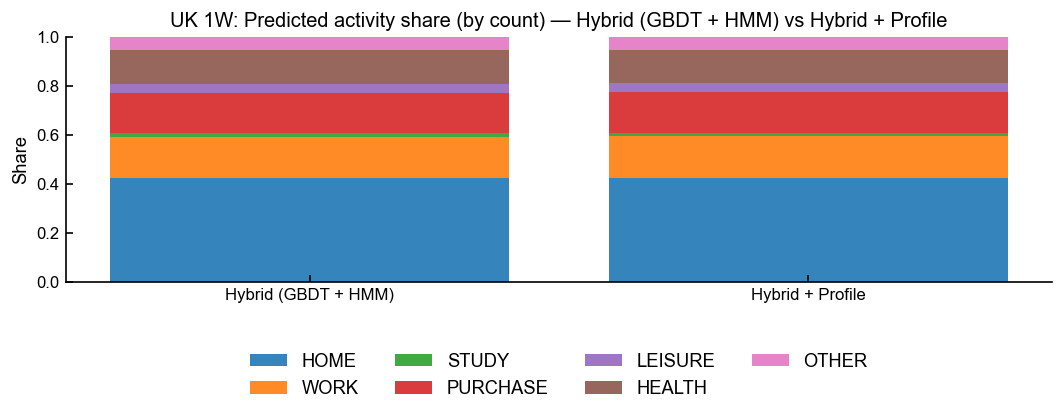

Saved: /Users/pang/Codes/GISRUK/outputs/figures/uk_1w_activity_share_count_s3_vs_s4.png


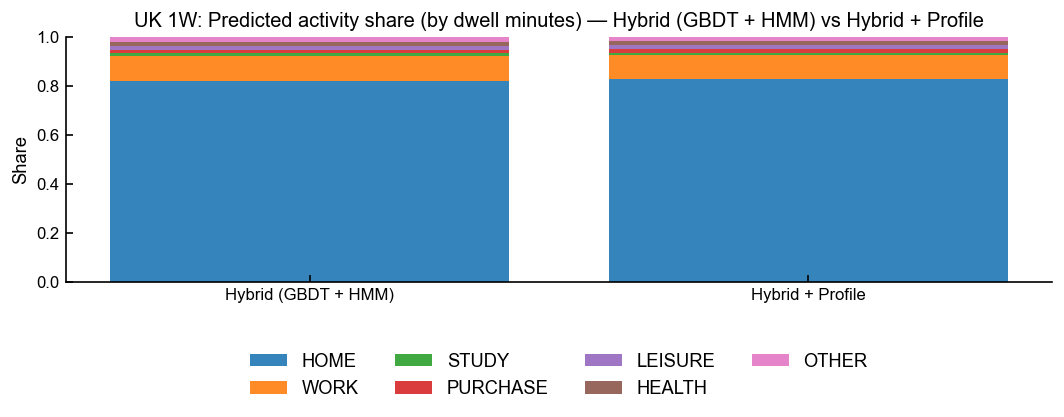

Saved: /Users/pang/Codes/GISRUK/outputs/figures/uk_1w_activity_share_dwell_s3_vs_s4.png


In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

apply_nature_style()

labels = ["HOME","WORK","STUDY","PURCHASE","LEISURE","HEALTH","OTHER"]

OUT_TAB = Path("/Users/pang/Codes/GISRUK/outputs/tables")
OUT_FIG = Path("/Users/pang/Codes/GISRUK/outputs/figures")
OUT_TAB.mkdir(parents=True, exist_ok=True)
OUT_FIG.mkdir(parents=True, exist_ok=True)

def activity_share_by_count(df, label_col):
    return df[label_col].value_counts(normalize=True).reindex(labels, fill_value=0)

def activity_share_by_dwell(df, label_col):
    g = df.groupby(label_col)["duration_min"].sum()
    return (g / g.sum()).reindex(labels, fill_value=0)

share_cnt = pd.DataFrame({
    "S3": activity_share_by_count(out_s3, "y_pred_s3"),
    "S4": activity_share_by_count(out_s4, "y_pred_s4"),
}).T

share_dwell = pd.DataFrame({
    "S3": activity_share_by_dwell(out_s3, "y_pred_s3"),
    "S4": activity_share_by_dwell(out_s4, "y_pred_s4"),
}).T

NAME_S3 = "Hybrid (GBDT + HMM)"
NAME_S4 = "Hybrid + Profile"

# activity share tables
share_cnt = share_cnt.rename(index={"S3": NAME_S3, "S4": NAME_S4})
share_dwell = share_dwell.rename(index={"S3": NAME_S3, "S4": NAME_S4})

# patterns table
share_pat = share_pat.rename(index={"S3": NAME_S3, "S4": NAME_S4})

share_cnt.to_csv(OUT_TAB / "uk_1w_activity_share_count_s3_vs_s4.csv")
share_dwell.to_csv(OUT_TAB / "uk_1w_activity_share_dwell_s3_vs_s4.csv")
print("Saved tables:",
      OUT_TAB / "uk_1w_activity_share_count_s3_vs_s4.csv",
      OUT_TAB / "uk_1w_activity_share_dwell_s3_vs_s4.csv")

def plot_stacked_share(df_share, title, outpath):
    fig, ax = plt.subplots(figsize=(9, 3.8))
    bottom = np.zeros(len(df_share))
    x = np.arange(len(df_share))
    for lab in labels:
        ax.bar(x, df_share[lab].values, bottom=bottom, label=lab, alpha=0.9)
        bottom += df_share[lab].values

    ax.set_xticks(x)
    ax.set_xticklabels(df_share.index.tolist())
    ax.set_ylim(0, 1.0)
    ax.set_ylabel("Share")
    ax.set_title(title)
    ax.legend(ncol=4, loc="upper center", bbox_to_anchor=(0.5, -0.22))
    ax.tick_params(direction="in")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print("Saved:", outpath)

plot_stacked_share(share_cnt, "UK 1W: Predicted activity share (by count) — Hybrid (GBDT + HMM) vs Hybrid + Profile",
                   OUT_FIG / "uk_1w_activity_share_count_s3_vs_s4.png")

plot_stacked_share(share_dwell, "UK 1W: Predicted activity share (by dwell minutes) — Hybrid (GBDT + HMM) vs Hybrid + Profile",
                   OUT_FIG / "uk_1w_activity_share_dwell_s3_vs_s4.png")

In [184]:
share_cnt

,HOME,WORK,STUDY,PURCHASE,LEISURE,HEALTH,OTHER
Hybrid (GBDT + HMM),0.422637,0.170535,0.012950,0.165489,0.036495,0.136731,0.055163
Hybrid + Profile,0.426337,0.169021,0.013791,0.165489,0.036495,0.136394,0.052472


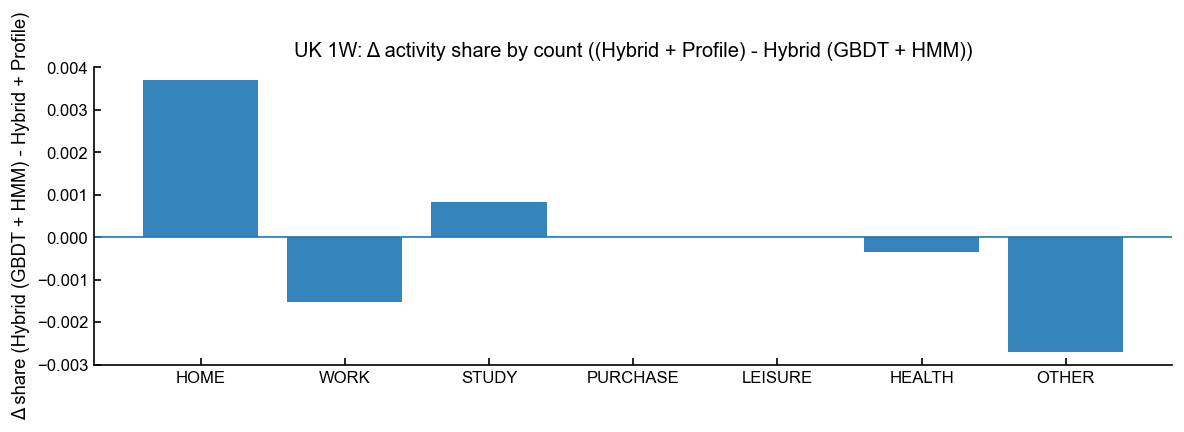

Saved: /Users/pang/Codes/GISRUK/outputs/figures/uk_1w_delta_activity_share_count.png


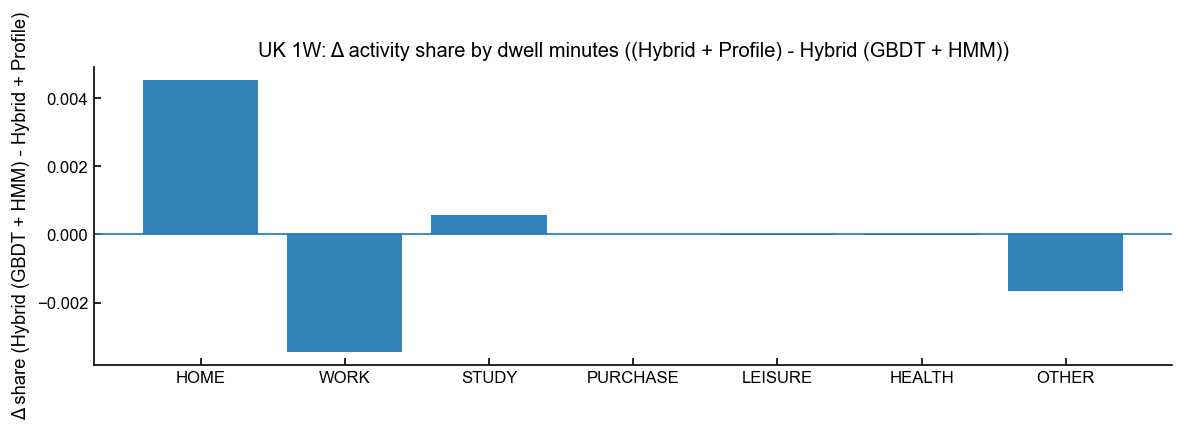

Saved: /Users/pang/Codes/GISRUK/outputs/figures/uk_1w_delta_activity_share_dwell.png


In [185]:
# After share_cnt / share_dwell computed (DataFrame index: ["S3","S4"])
share_cnt_delta = (share_cnt.loc["Hybrid + Profile"] - share_cnt.loc["Hybrid (GBDT + HMM)"]).reindex(labels)
share_dwell_delta = (share_dwell.loc["Hybrid + Profile"] - share_dwell.loc["Hybrid (GBDT + HMM)"]).reindex(labels)

def plot_delta_bar(delta, title, outpath):
    apply_nature_style()
    fig, ax = plt.subplots(figsize=(10, 3.2))
    x = np.arange(len(delta))
    ax.bar(x, delta.values, alpha=0.9)
    ax.axhline(0, linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels(delta.index.tolist(), rotation=0)
    ax.set_ylabel("Δ share (Hybrid (GBDT + HMM) - Hybrid + Profile)")
    ax.set_title(title)
    ax.tick_params(direction="in")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print("Saved:", outpath)

plot_delta_bar(share_cnt_delta,
               "UK 1W: Δ activity share by count ((Hybrid + Profile) - Hybrid (GBDT + HMM))",
               OUT_FIG / "uk_1w_delta_activity_share_count.png")

plot_delta_bar(share_dwell_delta,
               "UK 1W: Δ activity share by dwell minutes ((Hybrid + Profile) - Hybrid (GBDT + HMM))",
               OUT_FIG / "uk_1w_delta_activity_share_dwell.png")

User-days S3: 1757 S4: 1757
Top patterns used: ['H', 'H-W-H', 'H-He-H', 'H-P-H', 'W-H', 'H-L-H', 'H-W-He-H', 'H-W-P-H', 'He-H', 'H-O-H']
Saved: /Users/pang/Codes/GISRUK/outputs/tables/uk_1w_pattern_share_top12_s3_vs_s4.csv


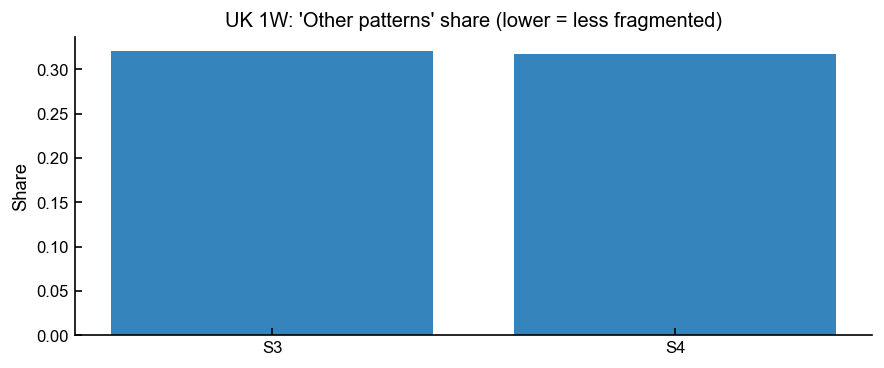

Saved: /Users/pang/Codes/GISRUK/outputs/figures/uk_1w_other_patterns_share_s3_vs_s4.png


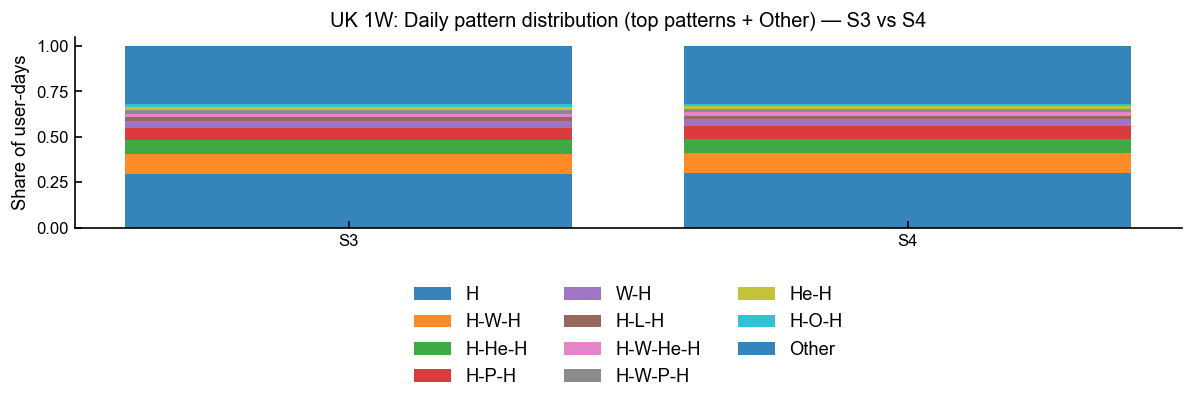

Saved: /Users/pang/Codes/GISRUK/outputs/figures/uk_1w_pattern_share_top12_s3_vs_s4.png


In [186]:
from src.utils_time import to_local_time_series, split_cross_midnight
from src.config import ABBR, TZ_LONDON

def collapse_consecutive(labels_list):
    out=[]
    for x in labels_list:
        if len(out)==0 or x!=out[-1]:
            out.append(x)
    return out

def build_daily_patterns(df, label_col, min_dur_min=10, tz=TZ_LONDON, assume_utc_if_naive=True):
    d = df.copy()
    d["start_time"] = to_local_time_series(d["start_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)
    d["end_time"]   = to_local_time_series(d["end_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)
    d["duration_min"] = pd.to_numeric(d["duration_min"], errors="coerce")
    d = d.dropna(subset=["user_id","start_time","end_time","duration_min",label_col]).copy()
    d = d[d["duration_min"] > 0].copy()

    d = split_cross_midnight(d)
    d = d[d["duration_min"] >= float(min_dur_min)].copy()

    d["date"] = d["start_time"].dt.date
    d["dow"] = d["start_time"].dt.weekday

    rows=[]
    for (u, date), g in d.groupby(["user_id","date"], sort=False):
        g = g.sort_values("start_time")
        labs = [x for x in g[label_col].astype(str).tolist() if x in ABBR]
        if not labs:
            continue
        labs2 = collapse_consecutive(labs)
        patt = "-".join([ABBR[x] for x in labs2])
        rows.append((u, date, int(g["dow"].iloc[0]), patt))
    return pd.DataFrame(rows, columns=["user_id","date","dow","pattern"])

def top_patterns_by_coverage(pat_df, coverage=0.9, min_count=10, max_n=12):
    vc = pat_df["pattern"].value_counts()
    vc = vc[vc >= min_count]
    cum = vc.cumsum()/vc.sum()
    keep = vc.index[cum <= coverage].tolist()
    keep = keep[:max_n]
    return keep

def pattern_share(pat_df, keep_list):
    tmp = pat_df.copy()
    tmp["pattern2"] = tmp["pattern"].where(tmp["pattern"].isin(keep_list), other="Other")
    return tmp["pattern2"].value_counts(normalize=True).reindex(keep_list+["Other"], fill_value=0)

# build user-day patterns
pat_s3 = build_daily_patterns(out_s3, label_col="y_pred_s3", min_dur_min=10)
pat_s4 = build_daily_patterns(out_s4, label_col="y_pred_s4", min_dur_min=10)

print("User-days S3:", len(pat_s3), "S4:", len(pat_s4))

# use S4 as reference to pick top patterns
keep = top_patterns_by_coverage(pat_s4, coverage=0.9, min_count=10, max_n=12)
print("Top patterns used:", keep)

share_pat = pd.DataFrame({
    "S3": pattern_share(pat_s3, keep),
    "S4": pattern_share(pat_s4, keep),
}).T

share_pat.to_csv(OUT_TAB / "uk_1w_pattern_share_top12_s3_vs_s4.csv")
print("Saved:", OUT_TAB / "uk_1w_pattern_share_top12_s3_vs_s4.csv")

# plot Other share
fig, ax = plt.subplots(figsize=(7.5, 3.2))
x = np.arange(len(share_pat))
ax.bar(x, share_pat["Other"].values, alpha=0.9)
ax.set_xticks(x)
ax.set_xticklabels(share_pat.index.tolist())
ax.set_ylabel("Share")
ax.set_title("UK 1W: 'Other patterns' share (lower = less fragmented)")
ax.tick_params(direction="in")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
out_png = OUT_FIG / "uk_1w_other_patterns_share_s3_vs_s4.png"
fig.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print("Saved:", out_png)

# stacked pattern distribution
fig, ax = plt.subplots(figsize=(10, 3.8))
bottom = np.zeros(len(share_pat))
x = np.arange(len(share_pat))
cols = keep + ["Other"]
for ptn in cols:
    ax.bar(x, share_pat[ptn].values, bottom=bottom, label=ptn, alpha=0.9)
    bottom += share_pat[ptn].values

ax.set_xticks(x)
ax.set_xticklabels(share_pat.index.tolist())
ax.set_ylabel("Share of user-days")
ax.set_title("UK 1W: Daily pattern distribution (top patterns + Other) — S3 vs S4")
ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, -0.22))
ax.tick_params(direction="in")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
out_png = OUT_FIG / "uk_1w_pattern_share_top12_s3_vs_s4.png"
fig.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print("Saved:", out_png)

In [187]:
# ---- Decode 1M with Stage3 & Stage4 using the same profiles learned from 3M ----
pred_1m_s3 = hybrid_decode_stage3(X_1m_df, proba_1m, T=T_TEMP, self_loop_bonus=SELF_LOOP)
pred_1m_s4 = hybrid_decode_with_profile(X_1m_df, proba_1m, profiles, T=T_TEMP, lam=LAMBDA_PROFILE, self_loop_bonus=SELF_LOOP)

# ---- Decode 3M final Stage4 already exists as pred_3m_s4 (from the loop); ensure it's available ----
pred_3m_s4 = hybrid_decode_with_profile(X_3m_df, proba_3m, profiles, T=T_TEMP, lam=LAMBDA_PROFILE, self_loop_bonus=SELF_LOOP)

def merge_pred(base_stays, pred_df, pred_col, out_col="y_pred"):
    return base_stays.merge(pred_df[["user_id","start_time","hex_id", pred_col]],
                            on=["user_id","start_time","hex_id"], how="left") \
                    .rename(columns={pred_col: out_col})

# Save HMM(Stage3) and Hybrid(Stage4) for 1W/1M/3M
OUT_DATA = Path("/Users/pang/Codes/GISRUK/outputs/data")
OUT_DATA.mkdir(parents=True, exist_ok=True)

uk_1w_hmm = merge_pred(uk_1w, pred_1w_s3, "y_pred_s3", out_col="y_pred")
uk_1w_hybrid = merge_pred(uk_1w, pred_1w_s4, "y_pred", out_col="y_pred")

uk_1m_hmm = merge_pred(uk_1m, pred_1m_s3, "y_pred_s3", out_col="y_pred")
uk_1m_hybrid = merge_pred(uk_1m, pred_1m_s4, "y_pred", out_col="y_pred")

# 3M: use final Stage4 decode
uk_3m_hybrid = merge_pred(uk_3m, pred_3m_s4, "y_pred", out_col="y_pred")

uk_1w_hmm.to_parquet(OUT_DATA / "uk_1w_pred_hmm.parquet", index=False)
uk_1w_hybrid.to_parquet(OUT_DATA / "uk_1w_pred_hybrid.parquet", index=False)

uk_1m_hmm.to_parquet(OUT_DATA / "uk_1m_pred_hmm.parquet", index=False)
uk_1m_hybrid.to_parquet(OUT_DATA / "uk_1m_pred_hybrid.parquet", index=False)

uk_3m_hybrid.to_parquet(OUT_DATA / "uk_3m_pred_hybrid.parquet", index=False)

print("Saved UK HMM/Hybrid parquets to outputs/data/")

Saved UK HMM/Hybrid parquets to outputs/data/


In [172]:
def gbdt_argmax_labels(proba, labels=ACTIVITIES):
    idx = np.argmax(proba, axis=1)
    return [labels[i] for i in idx]

uk_1w_gbdt = uk_1w.copy()
uk_1w_gbdt["y_pred"] = gbdt_argmax_labels(proba_1w)

uk_1m_gbdt = uk_1m.copy()
uk_1m_gbdt["y_pred"] = gbdt_argmax_labels(proba_1m)

uk_3m_gbdt = uk_3m.copy()
uk_3m_gbdt["y_pred"] = gbdt_argmax_labels(proba_3m)

uk_1w_gbdt.to_parquet(OUT_DATA / "uk_1w_pred_gbdt.parquet", index=False)
uk_1m_gbdt.to_parquet(OUT_DATA / "uk_1m_pred_gbdt.parquet", index=False)
uk_3m_gbdt.to_parquet(OUT_DATA / "uk_3m_pred_gbdt.parquet", index=False)

print("Saved UK GBDT parquets.")

Saved UK GBDT parquets.


In [173]:
def gbdt_argmax_labels(proba, labels=ACTIVITIES):
    idx = np.argmax(proba, axis=1)
    return [labels[i] for i in idx]

uk_1w_gbdt = uk_1w.copy()
uk_1w_gbdt["y_pred"] = gbdt_argmax_labels(proba_1w)

uk_1m_gbdt = uk_1m.copy()
uk_1m_gbdt["y_pred"] = gbdt_argmax_labels(proba_1m)

uk_3m_gbdt = uk_3m.copy()
uk_3m_gbdt["y_pred"] = gbdt_argmax_labels(proba_3m)

uk_1w_gbdt.to_parquet(OUT_DATA / "uk_1w_pred_gbdt.parquet", index=False)
uk_1m_gbdt.to_parquet(OUT_DATA / "uk_1m_pred_gbdt.parquet", index=False)
uk_3m_gbdt.to_parquet(OUT_DATA / "uk_3m_pred_gbdt.parquet", index=False)

print("Saved UK GBDT parquets.")

Saved UK GBDT parquets.


In [156]:
import math

# UK temporal signature (same table you provided, mapped to 7 labels)
HOURS = list(range(6,24))
UK = {
 "Education":      [0.1,0.7,0.9,0.5,0.3,0.3,0.3,0.3,0.3,0.5,0.3,0.3,0.3,0.3,0.3,0.1,0.1,0.1],
 "EatingDrinking": [0.1,0.7,0.7,0.5,0.5,0.9,0.9,0.7,0.5,0.3,0.5,0.7,0.9,0.9,0.5,0.5,0.3,0.3],
 "Shopping1":      [0.1,0.5,0.5,0.5,0.5,0.5,0.7,0.7,0.5,0.5,0.5,0.5,0.3,0.7,0.7,0.5,0.5,0.5],
 "Shopping2":      [0.1,0.1,0.1,0.5,0.7,0.7,0.3,0.5,0.7,0.7,0.7,0.7,0.1,0.1,0.1,0.1,0.1,0.1],
 "Entertainment":  [0.1,0.1,0.1,0.3,0.5,0.5,0.7,0.5,0.5,0.5,0.5,0.5,0.3,0.7,0.9,0.7,0.5,0.3],
 "Others":         [0.3,0.3,0.7,0.5,0.7,0.7,0.3,0.3,0.5,0.5,0.5,0.5,0.3,0.3,0.5,0.5,0.5,0.5],
}
def norm(p):
    p = np.maximum(np.array(p, dtype=float), 0)
    return p/p.sum()

TEMP = {}
TEMP["STUDY"] = norm(UK["Education"])
TEMP["PURCHASE"] = norm(np.maximum(UK["Shopping1"], UK["Shopping2"]))
TEMP["LEISURE"] = norm(np.maximum(UK["EatingDrinking"], UK["Entertainment"]))
TEMP["OTHER"] = norm(UK["Others"])
TEMP["HEALTH"] = norm(UK["Others"])  # approx

def temporal_prob(label, ts):
    h = ts.hour
    if h < 6 or h >= 24: return 1e-6
    return float(TEMP[label][h-6])

# POI lookup (Huff counts already)
poi_lookup_uk = {r.hex_id: r for r in uk_poi[["hex_id"]+POI_COLS].itertuples(index=False)}

def get_poi_counts(h):
    r = poi_lookup_uk.get(str(h))
    if r is None:
        return 0,0,0,0
    return (float(r.poi_edu_cnt), float(r.poi_health_cnt),
            float(r.poi_retail_cnt), float(r.poi_leisure_cnt))

def rule_based_predict(df):
    out = df.sort_values(["user_id","start_time"]).copy()
    pred=[]
    for r in out.itertuples(index=False):
        u = str(r.user_id); h = str(r.hex_id); st = r.start_time

        if home_uk.get(u) is not None and h == str(home_uk[u]):
            pred.append("HOME"); continue
        if work_uk.get(u) is not None and h == str(work_uk[u]):
            pred.append("WORK"); continue

        edu, health, retail, leisure = get_poi_counts(h)
        # scores for semantic classes
        cand = ["STUDY","HEALTH","PURCHASE","LEISURE","OTHER"]
        best_lab="OTHER"; best=-1e18
        eps=1e-8
        for lab in cand:
            cnt = {"STUDY":edu, "HEALTH":health, "PURCHASE":retail, "LEISURE":leisure}.get(lab, 0.0)
            sp = np.log1p(cnt)
            tm = temporal_prob(lab, st)
            score = math.log(eps+sp) + math.log(eps+tm)
            if score > best:
                best = score; best_lab = lab
        pred.append(best_lab)

    out["y_pred"] = pred
    return out

uk_1w_rule = rule_based_predict(uk_1w)
uk_1w_rule.to_parquet(OUT_DATA / "uk_1w_pred_rulebased.parquet", index=False)
print("Saved:", OUT_DATA / "uk_1w_pred_rulebased.parquet")

# Optional: do the same for 1M/3M if you want

Saved: /Users/pang/Codes/GISRUK/outputs/data/uk_1w_pred_rulebased.parquet


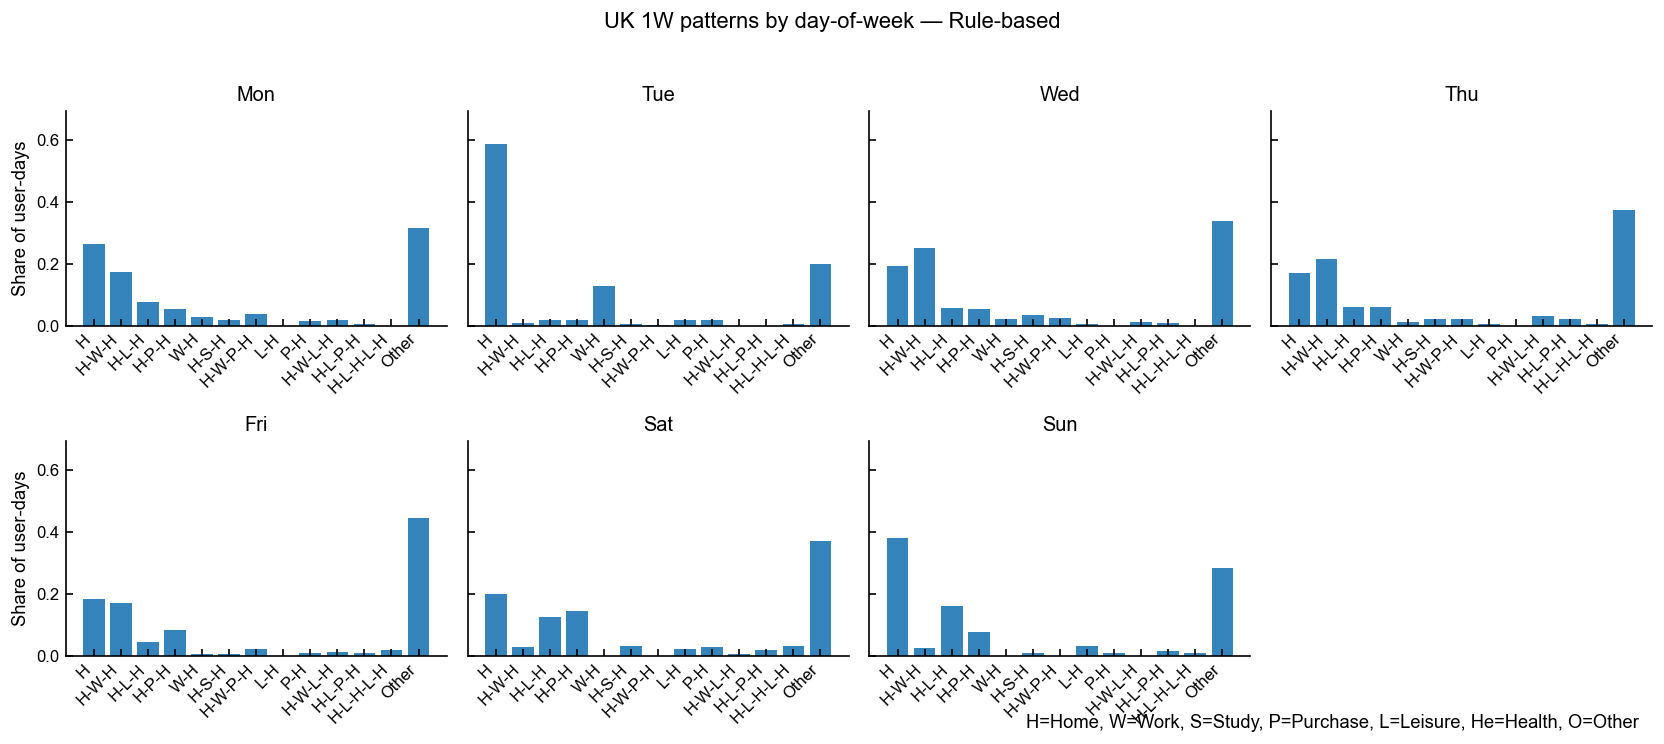

Saved: /Users/pang/Codes/GISRUK/outputs/figures/uk_1w_patterns_Rule-based.png


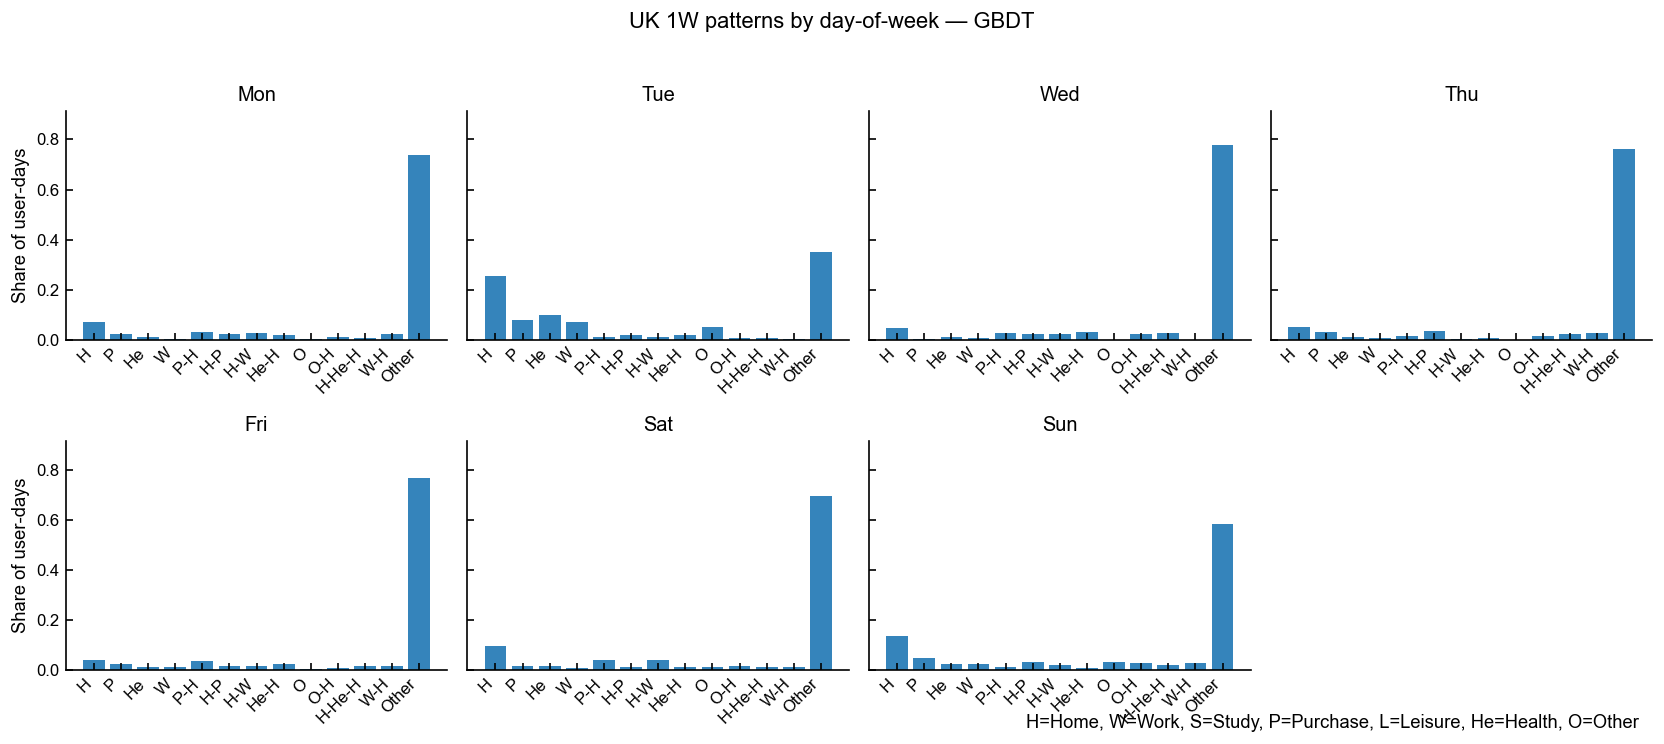

Saved: /Users/pang/Codes/GISRUK/outputs/figures/uk_1w_patterns_GBDT.png


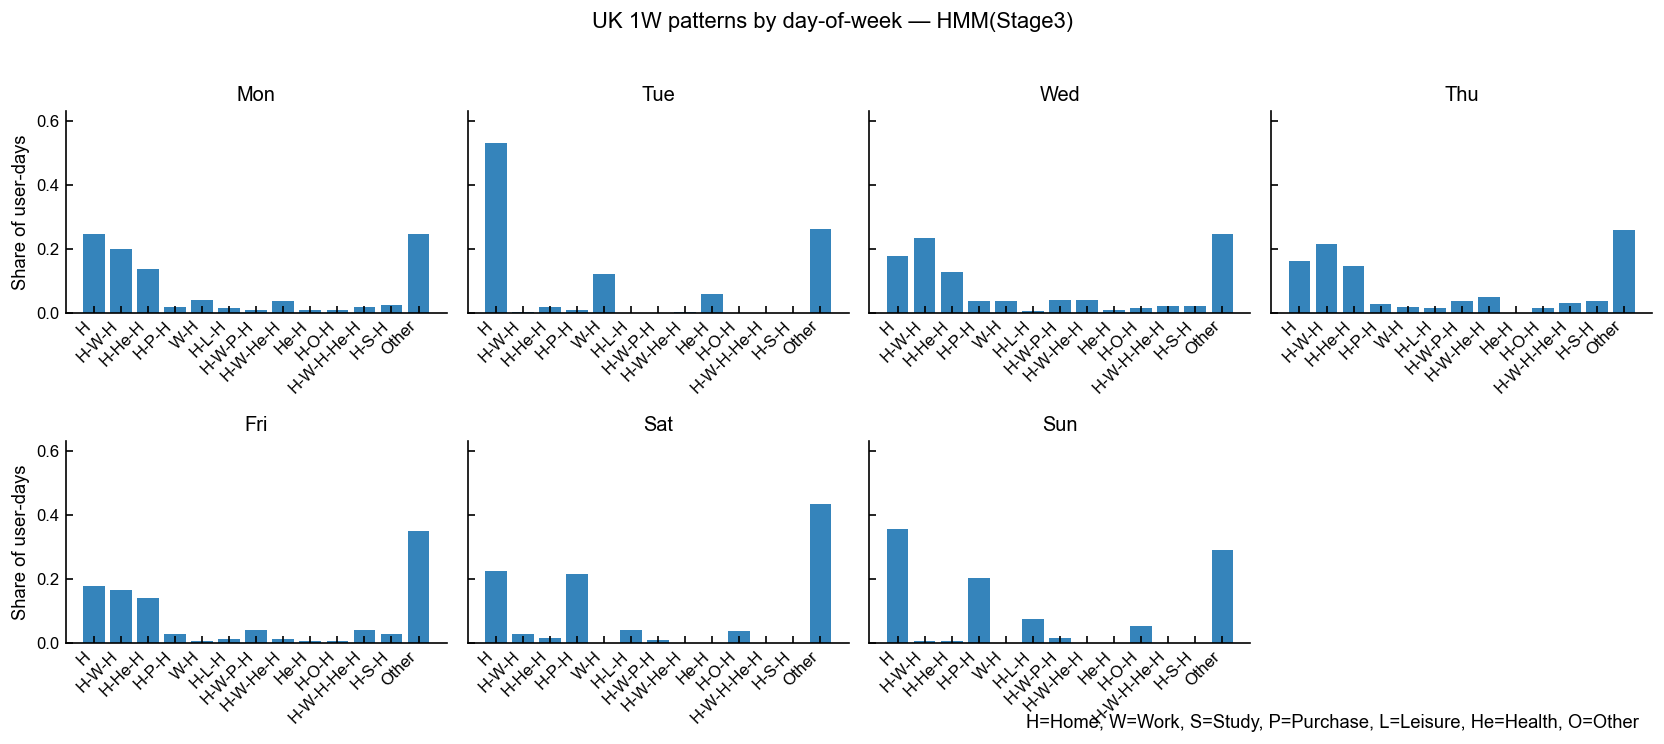

Saved: /Users/pang/Codes/GISRUK/outputs/figures/uk_1w_patterns_HMMStage3.png


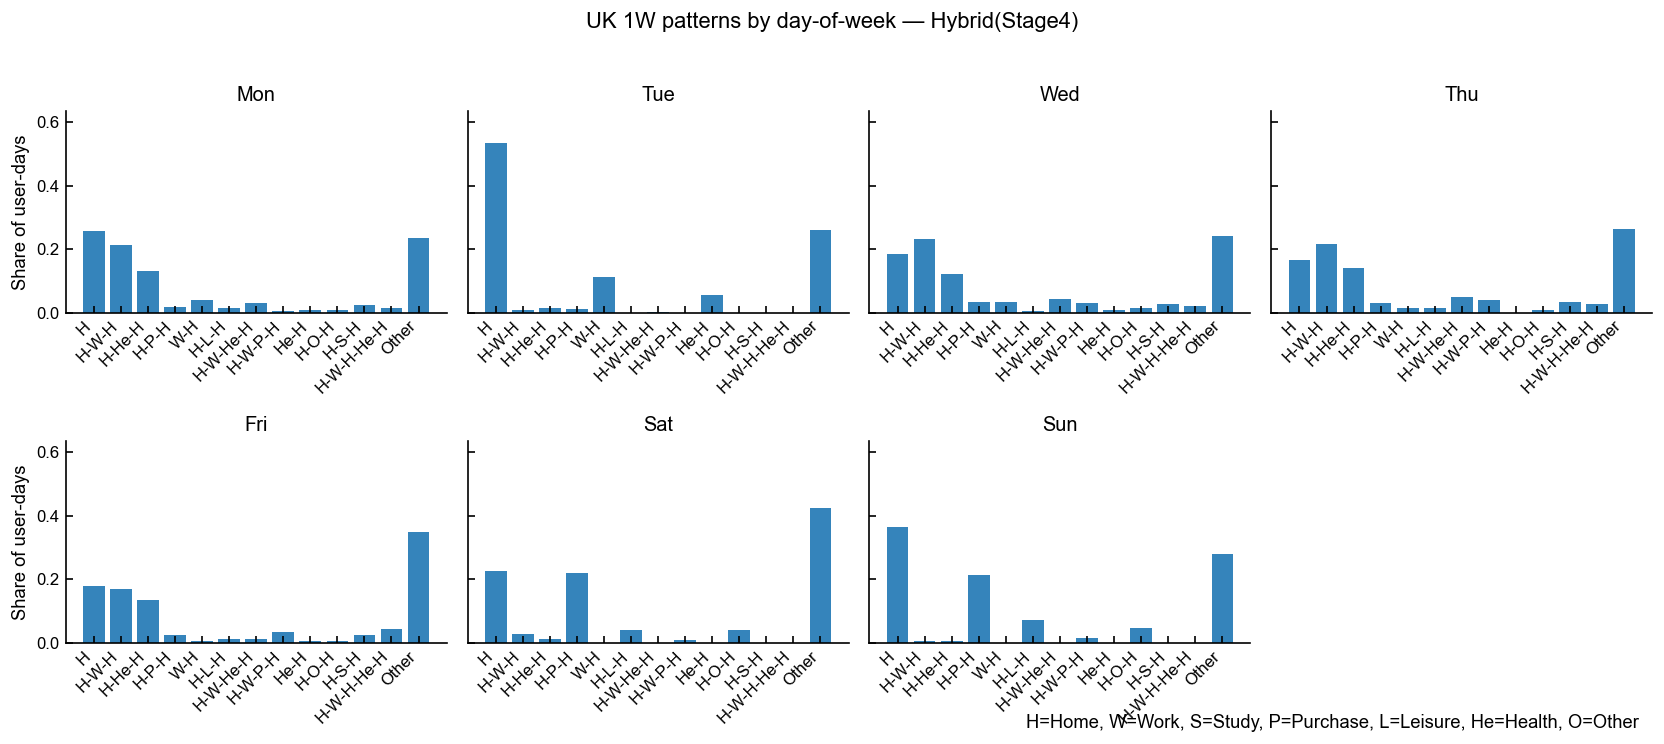

Saved: /Users/pang/Codes/GISRUK/outputs/figures/uk_1w_patterns_HybridStage4.png


In [188]:
# Reuse the same helper you used before (Paris-style small multiples)
from src.utils_time import to_local_time_series, split_cross_midnight
from src.config import ABBR, TZ_LONDON

def collapse_consecutive(labels_list):
    out=[]
    for x in labels_list:
        if len(out)==0 or x!=out[-1]:
            out.append(x)
    return out

def build_daily_patterns(df, label_col, min_dur_min=10, tz=TZ_LONDON, assume_utc_if_naive=True):
    d = df.copy()
    d["start_time"] = to_local_time_series(d["start_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)
    d["end_time"]   = to_local_time_series(d["end_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)
    d["duration_min"] = pd.to_numeric(d["duration_min"], errors="coerce")
    d = d.dropna(subset=["user_id","start_time","end_time","duration_min",label_col]).copy()
    d = d[d["duration_min"] > 0].copy()

    d = split_cross_midnight(d)
    d = d[d["duration_min"] >= float(min_dur_min)].copy()

    d["date"] = d["start_time"].dt.date
    d["dow"] = d["start_time"].dt.weekday

    rows=[]
    for (u, date), g in d.groupby(["user_id","date"], sort=False):
        g = g.sort_values("start_time")
        labs = [x for x in g[label_col].astype(str).tolist() if x in ABBR]
        if not labs:
            continue
        labs2 = collapse_consecutive(labs)
        patt = "-".join([ABBR[x] for x in labs2])
        rows.append((u, date, int(g["dow"].iloc[0]), patt))
    return pd.DataFrame(rows, columns=["user_id","date","dow","pattern"])

def select_patterns_by_coverage(patterns_df, coverage=0.90, max_n=12, min_count=10):
    vc = patterns_df["pattern"].value_counts()
    vc = vc[vc >= min_count]
    cum = vc.cumsum()/vc.sum()
    keep = vc.index[cum <= coverage].tolist()
    keep = keep[:max_n]
    return keep

def plot_patterns_by_dow_small_multiples(patterns_df, title, outpath, coverage=0.90, max_n=12, min_count=10):
    apply_nature_style()
    dow_names = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
    keep = select_patterns_by_coverage(patterns_df, coverage=coverage, max_n=max_n, min_count=min_count)

    tmp = patterns_df.copy()
    tmp["pattern2"] = tmp["pattern"].where(tmp["pattern"].isin(keep), other="Other")
    global_counts = tmp["pattern2"].value_counts()
    ordered = global_counts.index.tolist()
    top_order = [p for p in ordered if p != "Other"][:max_n]
    if "Other" in ordered:
        top_order = top_order + ["Other"]

    tab = tmp.groupby(["dow","pattern2"]).size().unstack(fill_value=0).reindex(index=range(7), fill_value=0)
    tab = tab.reindex(columns=top_order, fill_value=0)
    share = tab.div(tab.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)

    fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharey=True)
    axes = axes.flatten()
    x = np.arange(len(top_order))
    for d in range(7):
        ax = axes[d]
        ax.bar(x, share.loc[d].values, alpha=0.9)
        ax.set_title(dow_names[d])
        ax.set_ylim(0, min(1.0, float(share.values.max())*1.15 + 0.02))
        ax.tick_params(direction="in")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_xticks(x)
        ax.set_xticklabels(top_order, rotation=45, ha="right")
        if d % 4 == 0:
            ax.set_ylabel("Share of user-days")
    axes[7].axis("off")
    fig.suptitle(title, y=1.02)
    fig.text(0.98, 0.02, "H=Home, W=Work, S=Study, P=Purchase, L=Leisure, He=Health, O=Other",
             ha="right", va="bottom", fontsize=11)
    fig.subplots_adjust(hspace=0.40, wspace=0.05)
    plt.tight_layout()
    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print("Saved:", outpath)

# Load the 4 model outputs you just saved
uk_rule = pd.read_parquet(OUT_DATA / "uk_1w_pred_rulebased.parquet")
uk_gbdt = pd.read_parquet(OUT_DATA / "uk_1w_pred_gbdt.parquet")
uk_hmm  = pd.read_parquet(OUT_DATA / "uk_1w_pred_hmm.parquet")
uk_hybr = pd.read_parquet(OUT_DATA / "uk_1w_pred_hybrid.parquet")

for name, df in [("Rule-based", uk_rule), ("GBDT", uk_gbdt), ("HMM(Stage3)", uk_hmm), ("Hybrid(Stage4)", uk_hybr)]:
    pat = build_daily_patterns(df, label_col="y_pred", min_dur_min=10)
    plot_patterns_by_dow_small_multiples(
        pat,
        title=f"UK 1W patterns by day-of-week — {name}",
        outpath=OUT_FIG / f"uk_1w_patterns_{name.replace('/','_').replace('(','').replace(')','').replace(' ','_')}.png",
        coverage=0.90, max_n=12, min_count=5
    )

## TEST PERFORMANCE BETWEEN SPLIT_BY_GAP AND SPLIT_BY_DAY_OR_GAP

In [158]:
def hybrid_decode_stage3_generic(df_feat, proba, splitter, T=0.5, self_loop_bonus=0.1, tz="Europe/London"):
    df = df_feat.sort_values(["user_id","start_time"]).copy()
    df["proba_row"] = list(proba)
    df["y_pred"] = None

    for u, g in df.groupby("user_id", sort=False):
        parts = splitter(g, tz=tz)
        for seq in parts:
            P = np.stack(seq["proba_row"].values, axis=0)
            logB = np.log(np.clip(P, 1e-12, 1.0)) / T
            logB = add_home_constraint(logB, seq, u)  #  home constraint
            path = viterbi_decode(logB, seq, self_loop_bonus=self_loop_bonus)
            df.loc[seq.index, "y_pred"] = [i2act[int(i)] for i in path]
    return df

def hybrid_decode_stage4_generic(df_feat, proba, profiles, splitter, T=0.5, lam=0.25, self_loop_bonus=0.1, tz="Europe/London"):
    df = df_feat.sort_values(["user_id","start_time"]).copy()
    df["proba_row"] = list(proba)
    df["y_pred"] = None

    for u, g in df.groupby("user_id", sort=False):
        parts = splitter(g, tz=tz)
        p_u = profiles.get(u, np.full(K, 1.0/K))
        log_prior = np.log(np.clip(p_u, 1e-12, 1.0))

        for seq in parts:
            P = np.stack(seq["proba_row"].values, axis=0)
            logB = np.log(np.clip(P, 1e-12, 1.0)) / T
            logB = logB + lam * log_prior[None, :]
            logB = add_home_constraint(logB, seq, u, home_area_uk)
            path = viterbi_decode(logB, seq, self_loop_bonus=self_loop_bonus)
            df.loc[seq.index, "y_pred"] = [i2act[int(i)] for i in path]
    return df

In [122]:
# old splitter wrapper (keep your original behaviour)
def splitter_gap8(g, tz="Europe/London"):
    return split_by_gap(g, break_gap_hours=8)

# new splitter (day-aware)
def splitter_day_gap(g, tz="Europe/London"):
    return split_by_day_or_gap(g, tz=tz, gap_hours=8, max_len=200)

T_TEMP = 0.5
SELF_LOOP = 0.1

# Stage3
pred_1m_s3_gap = hybrid_decode_stage3_generic(X_1m_df, proba_1m, splitter_gap8, T=T_TEMP, self_loop_bonus=SELF_LOOP, tz=TZ_LONDON)
pred_1m_s3_day = hybrid_decode_stage3_generic(X_1m_df, proba_1m, splitter_day_gap, T=T_TEMP, self_loop_bonus=SELF_LOOP, tz=TZ_LONDON)

# Stage4 (use existing profiles learned from 3M)
pred_1m_s4_gap = hybrid_decode_stage4_generic(X_1m_df, proba_1m, profiles, splitter_gap8, T=T_TEMP, lam=LAMBDA_PROFILE, self_loop_bonus=SELF_LOOP, tz=TZ_LONDON)
pred_1m_s4_day = hybrid_decode_stage4_generic(X_1m_df, proba_1m, profiles, splitter_day_gap, T=T_TEMP, lam=LAMBDA_PROFILE, self_loop_bonus=SELF_LOOP, tz=TZ_LONDON)

print("Done. Label dist (Stage4):")
print("gap8:", pred_1m_s4_gap["y_pred"].value_counts(normalize=True))
print("day+gap:", pred_1m_s4_day["y_pred"].value_counts(normalize=True))

TypeError: add_home_constraint() takes 3 positional arguments but 4 were given

In [115]:
def label_switch_rate(df_week, label_col, tz=TZ_LONDON):
    d = df_week.copy()
    d["start_time"] = to_local_time_series(d["start_time"], tz=tz, assume_utc_if_naive=True)
    d = d.sort_values(["user_id","start_time"]).copy()
    d["date"] = d["start_time"].dt.date

    def switches_one_day(g):
        labs = g[label_col].astype(str).values
        if len(labs) <= 1:
            return 0
        return int(np.sum(labs[1:] != labs[:-1]))

    sw = d.groupby(["user_id","date"]).apply(switches_one_day)
    # average over user-days
    return float(sw.mean()) if len(sw) else 0.0

# merge predictions back to uk_1m base
base_1m = uk_1m.copy()

def merge_pred(base, pred_df, col_pred, out_col):
    return base.merge(pred_df[["user_id","start_time","hex_id", col_pred]],
                      on=["user_id","start_time","hex_id"], how="left").rename(columns={col_pred: out_col})

out_gap_s3 = merge_pred(base_1m, pred_1m_s3_gap, "y_pred", "label")
out_day_s3 = merge_pred(base_1m, pred_1m_s3_day, "y_pred", "label")
out_gap_s4 = merge_pred(base_1m, pred_1m_s4_gap, "y_pred", "label")
out_day_s4 = merge_pred(base_1m, pred_1m_s4_day, "y_pred", "label")

def proxy_pack(df, label_col="label"):
    nh = night_home_share(df.rename(columns={label_col:"tmp"}), label_col="tmp")
    ent = tophex_entropy(df.rename(columns={label_col:"tmp"}), label_col="tmp")
    sw = label_switch_rate(df, label_col=label_col, tz=TZ_LONDON)
    return float(nh.mean()), float(nh.median()), float(ent.mean()), float(ent.median()), sw

rows = []
for name, df in [
    ("S3 gap8", out_gap_s3),
    ("S3 day+gap", out_day_s3),
    ("S4 gap8", out_gap_s4),
    ("S4 day+gap", out_day_s4),
]:
    nh_mean, nh_med, ent_mean, ent_med, sw = proxy_pack(df, "label")
    rows.append({
        "setting": name,
        "nh_mean": nh_mean, "nh_median": nh_med,
        "ent_mean": ent_mean, "ent_median": ent_med,
        "switch_rate": sw,
    })

proxy_df = pd.DataFrame(rows)
proxy_df.to_csv(OUT_TAB / "uk_1m_split_compare_proxies.csv", index=False)
print("Saved:", OUT_TAB / "uk_1m_split_compare_proxies.csv")
proxy_df

Saved: /Users/pang/Codes/GISRUK/outputs/tables/uk_1m_split_compare_proxies.csv


,setting,nh_mean,nh_median,ent_mean,ent_median,switch_rate
0,S3 gap8,0.973599,0.990184,0.330610,0.302652,1.862430
1,S3 day+gap,0.970206,0.989252,0.355328,0.324239,1.876024
2,S4 gap8,0.974363,0.990500,0.325131,0.301746,1.855879
3,S4 day+gap,0.973091,0.990340,0.349153,0.329520,1.865706


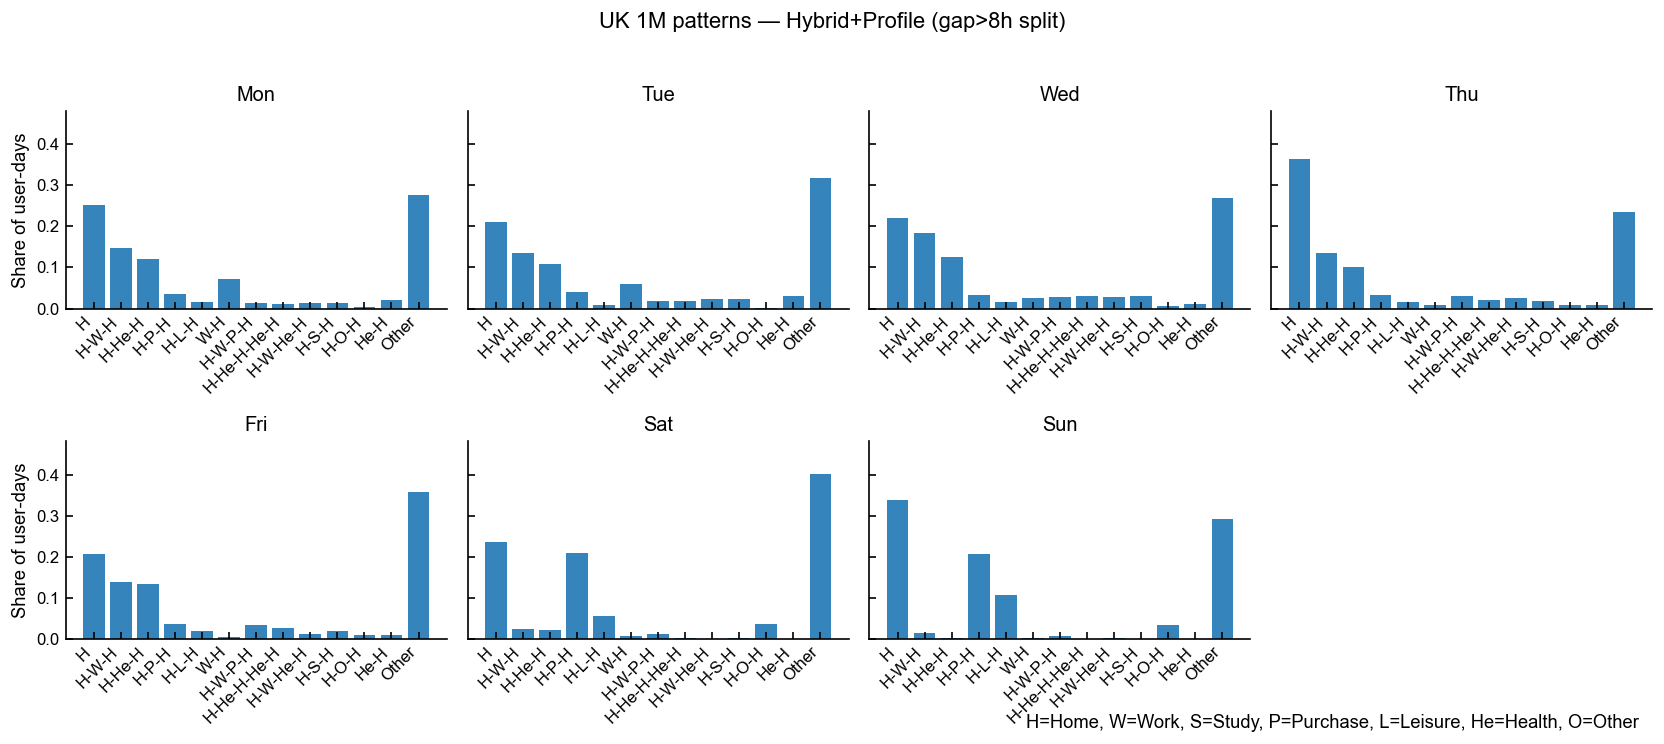

Saved: /Users/pang/Codes/GISRUK/outputs/figures/uk_1m_patterns_stage4_gap8.png


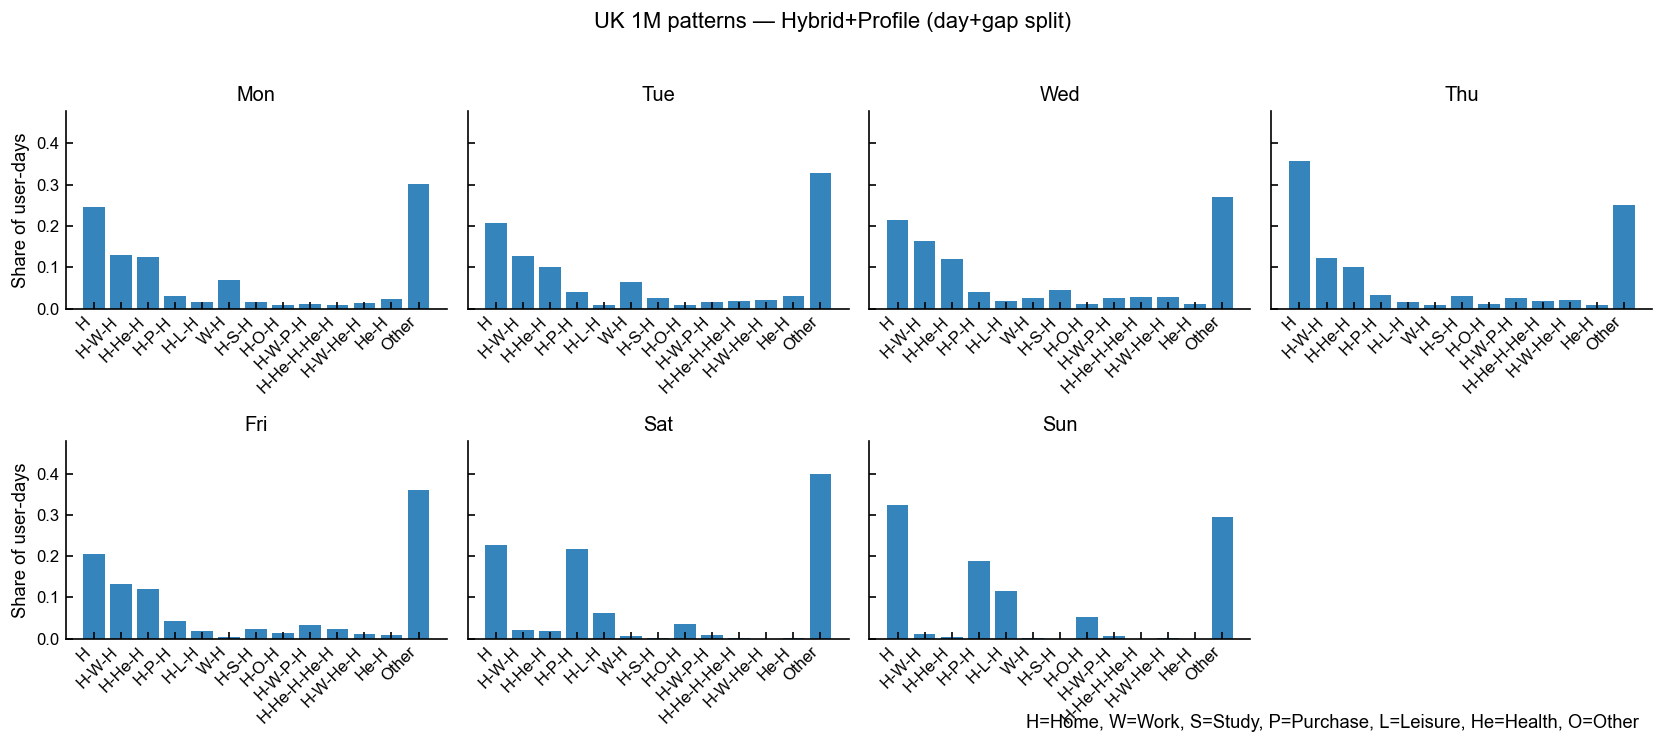

Saved: /Users/pang/Codes/GISRUK/outputs/figures/uk_1m_patterns_stage4_day_gap.png


In [116]:
pat_gap_s4 = build_daily_patterns(out_gap_s4.rename(columns={"label":"y_pred"}), label_col="y_pred",
                                 min_dur_min=10, tz=TZ_LONDON, assume_utc_if_naive=True)
pat_day_s4 = build_daily_patterns(out_day_s4.rename(columns={"label":"y_pred"}), label_col="y_pred",
                                 min_dur_min=10, tz=TZ_LONDON, assume_utc_if_naive=True)

plot_patterns_by_dow_small_multiples(
    pat_gap_s4, title="UK 1M patterns — Hybrid+Profile (gap>8h split)",
    outpath=str(OUT_FIG / "uk_1m_patterns_stage4_gap8.png"),
    coverage=0.90, max_n=12, min_count=10
)

plot_patterns_by_dow_small_multiples(
    pat_day_s4, title="UK 1M patterns — Hybrid+Profile (day+gap split)",
    outpath=str(OUT_FIG / "uk_1m_patterns_stage4_day_gap.png"),
    coverage=0.90, max_n=12, min_count=10
)

### CONCLUSION: USE SIMPLE split_by_gap(8h)

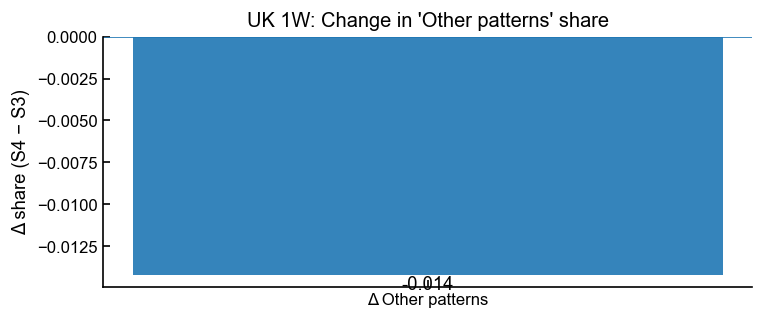

Saved: /Users/pang/Codes/GISRUK/outputs/figures/uk_1w_delta_other_patterns_share.png


In [22]:
delta_other = float(share_pat.loc["S4","Other"] - share_pat.loc["S3","Other"])

apply_nature_style()
fig, ax = plt.subplots(figsize=(6.5, 2.8))
ax.bar([0], [delta_other], alpha=0.9)
ax.axhline(0, linewidth=1)
ax.set_xticks([0])
ax.set_xticklabels(["Δ Other patterns"])
ax.set_ylabel("Δ share (S4 − S3)")
ax.set_title("UK 1W: Change in 'Other patterns' share")
ax.tick_params(direction="in")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.text(0, delta_other, f"{delta_other:+.3f}", ha="center", va="bottom" if delta_other>=0 else "top")
plt.tight_layout()
out_png = OUT_FIG / "uk_1w_delta_other_patterns_share.png"
fig.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print("Saved:", out_png)

In [20]:
import json

# recompute per-user entropy (tophex) & night_home_share for S3/S4 (you already had series; compute fresh for join)
ent_s3_u = tophex_entropy(out_s3, label_col="y_pred_s3")
ent_s4_u = tophex_entropy(out_s4, label_col="y_pred_s4")
nh_s3_u = night_home_share(out_s3, label_col="y_pred_s3")
nh_s4_u = night_home_share(out_s4, label_col="y_pred_s4")

users = sorted(out_s4["user_id"].unique())
df_u = pd.DataFrame({
    "user_id": users,
})
df_u["entropy_s3"] = ent_s3_u.values
df_u["entropy_s4"] = ent_s4_u.values
df_u["entropy_drop"] = df_u["entropy_s3"] - df_u["entropy_s4"]
df_u["nh_s3"] = nh_s3_u.values
df_u["nh_s4"] = nh_s4_u.values

# sample packs
top_high = df_u.sort_values("entropy_s4", ascending=False).head(10)
top_low  = df_u.sort_values("entropy_s4", ascending=True).head(10)
top_drop = df_u.sort_values("entropy_drop", ascending=False).head(10)

pack = pd.concat([
    top_high.assign(group="entropy_high"),
    top_low.assign(group="entropy_low"),
    top_drop.assign(group="entropy_drop_high"),
], ignore_index=True)

pack_path = OUT_TAB / "uk_1w_review_sample_pack.csv"
pack.to_csv(pack_path, index=False)
print("Saved:", pack_path)
pack

Saved: /Users/pang/Codes/GISRUK/outputs/tables/uk_1w_review_sample_pack.csv


,user_id,entropy_s3,entropy_s4,entropy_drop,nh_s3,nh_s4,group
0,F1872874C085E421E68859FA68A7C559,0.796729,0.778479,0.018250,0.938799,0.954175,entropy_high
1,516C7EEABF0F6489662C619A0C387116,0.758749,0.758749,0.000000,1.000000,1.000000,entropy_high
2,5C3CA9B08030C6109FD6AE539E3C540E,0.655857,0.655857,0.000000,1.000000,1.000000,entropy_high
3,3A7ACFDA991006B038F735FDC4221CA9,0.478737,0.478737,0.000000,1.000000,1.000000,entropy_high
4,5CCE0B6674FCD8B3120F799C42C64441,0.454602,0.454602,0.000000,1.000000,1.000000,entropy_high
5,2F0794FBF1510A8079ED722EB6EF7D10,0.442217,0.442217,0.000000,1.000000,1.000000,entropy_high
6,92E105D334FCD4E108A85D1640CFDF7F,0.421262,0.421262,0.000000,0.981460,0.981460,entropy_high
7,FDDAF10669EFDD40500C8C3096C4415A,0.413868,0.413868,0.000000,0.867145,0.867145,entropy_high
8,32C7ACE8A6EC37F2098406129749AA81,0.417525,0.410225,0.007299,0.997875,0.997875,entropy_high
9,DA1855E353A1425531BE92AC1B59B838,0.452482,0.405994,0.046488,0.733571,0.733571,entropy_high


### FOUND MULTI HOME LOCATION ISSUE, CHECK IT

In [189]:
# choose which dataframe: out_s4 (UK 1W Stage4)
df = out_s4.copy()
label_col = "y_pred_s4"

# night flag by midpoint
mid = df["start_time"] + pd.to_timedelta(df["duration_min"]/2, unit="m")
hh = mid.dt.hour + mid.dt.minute/60.0
df["is_night"] = (hh >= 20) | (hh < 6)

# per-user: number of distinct HOME hex at night
night_home = df[(df["is_night"]) & (df[label_col] == "HOME")].copy()
home_hex_cnt = night_home.groupby("user_id")["hex_id"].nunique()

print("share users with night HOME hex >=2:", float((home_hex_cnt >= 2).mean()))
print("share users with night HOME hex >=3:", float((home_hex_cnt >= 3).mean()))
print("home hex count describe:\n", home_hex_cnt.describe())

# fraction of those HOME hex that are within home_area_uk
def frac_home_hex_in_area(u):
    ha = home_area_uk.get(u, set())
    hs = set(night_home[night_home["user_id"]==u]["hex_id"].unique())
    if not hs:
        return np.nan
    return len(hs & ha) / len(hs)

frac_in_area = pd.Series({u: frac_home_hex_in_area(u) for u in home_hex_cnt.index})
print("\nFor users with >=2 night HOME hex: fraction of their HOME hex inside home_area")
print(frac_in_area[home_hex_cnt >= 2].describe())

# show a few problematic users
bad_users = frac_in_area[home_hex_cnt >= 2].sort_values().head(10).index.tolist()
print("\nExample 'bad' users (multi-home, low in-area fraction):", bad_users[:10])

# detailed per-user breakdown function
def home_hex_diagnose(df_s4, user_id):
    d = df_s4[df_s4["user_id"] == user_id].copy()
    mid = d["start_time"] + pd.to_timedelta(d["duration_min"]/2, unit="m")
    hh = mid.dt.hour + mid.dt.minute/60.0
    night = (hh >= 20) | (hh < 6)
    d = d[(night) & (d[label_col] == "HOME")].copy()
    if len(d)==0:
        return None
    stats = d.groupby("hex_id")["duration_min"].sum().sort_values(ascending=False)
    ha = home_area_uk.get(user_id, set())
    return pd.DataFrame({
        "night_home_dwell_min": stats.values,
        "in_home_area": [h in ha for h in stats.index]
    }, index=stats.index)

# inspect one user
if bad_users:
    u0 = bad_users[0]
    display(home_hex_diagnose(df, u0))

share users with night HOME hex >=2: 0.06926406926406926
share users with night HOME hex >=3: 0.0
home hex count describe:
 count    231.000000
mean       1.069264
std        0.254454
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: hex_id, dtype: float64

For users with >=2 night HOME hex: fraction of their HOME hex inside home_area
count    16.000000
mean      0.937500
std       0.170783
min       0.500000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
dtype: float64

Example 'bad' users (multi-home, low in-area fraction): ['C9A5DFA0CBBF7ABA995D2B3324255520', 'CEE2B0DE8DDF1F6D0AED748E22DF26C5', '0563F3A489DE7C55111D4CB35721B569', '26771C7E313FE8839F411F0A008E983B', '2FCCA2E0399138C3C5E9DE94173AD9BB', '3592639C37BB0E1F380E11881F438C8E', '37A53BF21ED0DD6B1B4A39852EACFE30', '3AD89DA5449FB377AED80FA5F1D5D04B', '51B55250C9932CB267A096A6009F3A8A', '5B19570F4FAB6A069AD0D80E6178A218']


,night_home_dwell_min,in_home_area
hex_id,,
8a194e68cc97fff,3602.900000,True
8a194e68c537fff,6.083333,False


In [190]:
TH = 60  # minutes
night_home = df[(df["is_night"]) & (df[label_col]=="HOME")].copy()
home_dwell = night_home.groupby(["user_id","hex_id"])["duration_min"].sum()
home_hex_cnt_60 = home_dwell[home_dwell >= TH].groupby("user_id").size()

print("share users with night HOME hex>=2 (dwell>=60min):",
      float((home_hex_cnt_60 >= 2).mean()))

share users with night HOME hex>=2 (dwell>=60min): 0.05627705627705628


In [191]:
TH = 60
night_home = df[(df["is_night"]) & (df[label_col]=="HOME")].copy()
dwell = night_home.groupby(["user_id","hex_id"])["duration_min"].sum()

ratios=[]
for u in dwell.index.get_level_values(0).unique():
    s = dwell.loc[u].sort_values(ascending=False)
    if len(s)>=2 and s.iloc[1] >= TH:
        ratios.append(float(s.iloc[1] / max(s.iloc[0], 1e-6)))
pd.Series(ratios).describe()

count    13.000000
mean      0.215996
std       0.134164
min       0.078032
25%       0.145953
50%       0.180385
75%       0.242839
max       0.552254
dtype: float64

In [195]:
night_home[night_home["duration_min"]<60]

,user_id,start_time,end_time,activity_duration,hex_id,lat,lon,duration_min,y_pred_s4,is_night
1007,3AD89DA5449FB377AED80FA5F1D5D04B,2021-10-12 20:42:12,2021-10-12 20:57:31,919,8a194e6a9c47fff,51.564679,0.137943,15.316667,HOME,True
1018,3AD89DA5449FB377AED80FA5F1D5D04B,2021-10-13 20:40:36,2021-10-13 20:47:21,405,8a194e6a9c4ffff,51.563509,0.138873,6.750000,HOME,True
1052,3AD89DA5449FB377AED80FA5F1D5D04B,2021-10-18 04:44:58,2021-10-18 04:55:24,626,8a194e6a9c47fff,51.564679,0.137943,10.433333,HOME,True
1257,4B049236D3C7DF7267CC6C84B1982783,2021-10-12 19:47:39,2021-10-12 20:26:01,2302,8a194e6a2517fff,51.634885,0.044868,38.366667,HOME,True
1820,5C9F076E35967A3A07C28D012DC1F9E6,2021-10-15 20:01:36,2021-10-15 20:08:11,395,8a194ad9bc17fff,51.396995,-0.346927,6.583333,HOME,True
2387,72F6FCA8F1A60E25CC58319FD676A5CD,2021-10-16 20:57:29,2021-10-16 21:56:08,3519,8a195dadbb37fff,51.513588,-0.473619,58.650000,HOME,True
2583,823DDBF89A46141E5158CBD1DB24C07C,2021-10-13 21:15:17,2021-10-13 21:22:41,444,8a194e6ad48ffff,51.579544,0.135154,7.400000,HOME,True
2624,8285447F0CBEA0FC9101CBB6EA05D8BA,2021-10-15 20:39:04,2021-10-15 21:13:21,2057,8a194e6a9c4ffff,51.563770,0.138021,34.283333,HOME,True
3258,A0F378FF0D965BFB0D6C137F6C66591B,2021-10-15 21:43:00,2021-10-15 21:51:21,501,8a194e6ea75ffff,51.445729,0.225489,8.350000,HOME,True
3745,B19AF84FDACAABB97B6AA03B9A12F868,2021-10-18 05:18:19,2021-10-18 06:16:40,3501,8a194ac04cb7fff,51.352598,-0.126350,58.350000,HOME,True


In [196]:
TH_MIN = 60  # secondary night-home threshold in minutes
LABEL_COL = "y_pred_s4"  # or y_pred, depending on your df

# df should be your Stage4 1W output (e.g., out_s4)
df2 = out_s4.copy()
df2["start_time"] = pd.to_datetime(df2["start_time"])
df2["duration_min"] = pd.to_numeric(df2["duration_min"], errors="coerce").fillna(0.0)
df2["hex_id"] = df2["hex_id"].astype(str)

mid = df2["start_time"] + pd.to_timedelta(df2["duration_min"]/2, unit="m")
hh = mid.dt.hour + mid.dt.minute/60.0
df2["is_night"] = (hh >= 20) | (hh < 6)

night_home = df2[(df2["is_night"]) & (df2[LABEL_COL] == "HOME")].copy()

# night-home dwell per user-hex
dwell = night_home.groupby(["user_id","hex_id"])["duration_min"].sum()

rows = []
for u in dwell.index.get_level_values(0).unique():
    s = dwell.loc[u].sort_values(ascending=False)
    if len(s) >= 2 and s.iloc[1] >= TH_MIN:
        rows.append({
            "user_id": u,
            "primary_hex": s.index[0],
            "primary_night_home_min": float(s.iloc[0]),
            "secondary_hex": s.index[1],
            "secondary_night_home_min": float(s.iloc[1]),
            "secondary_over_primary": float(s.iloc[1] / max(s.iloc[0], 1e-6)),
            "n_night_home_hex_ge60": int((s >= TH_MIN).sum()),
        })

sec = pd.DataFrame(rows).sort_values(["secondary_night_home_min","secondary_over_primary"], ascending=False)
print("secondary-night-home users (>=60min):", len(sec))

out_csv = OUT_TAB / "uk_1w_secondary_night_home_users_ge60min.csv"
sec.to_csv(out_csv, index=False)
print("Saved:", out_csv)

# optional summary
if len(sec):
    print(sec[["secondary_night_home_min","secondary_over_primary","n_night_home_hex_ge60"]].describe())
sec.head(10)

secondary-night-home users (>=60min): 13
Saved: /Users/pang/Codes/GISRUK/outputs/tables/uk_1w_secondary_night_home_users_ge60min.csv
       secondary_night_home_min  secondary_over_primary  n_night_home_hex_ge60
count                 13.000000               13.000000                   13.0
mean                 748.538462                0.215996                    2.0
std                  266.324849                0.134164                    0.0
min                  303.516667                0.078032                    2.0
25%                  546.400000                0.145953                    2.0
50%                  740.666667                0.180385                    2.0
75%                  988.483333                0.242839                    2.0
max                 1083.283333                0.552254                    2.0


,user_id,primary_hex,primary_night_home_min,secondary_hex,secondary_night_home_min,secondary_over_primary,n_night_home_hex_ge60
5,51B55250C9932CB267A096A6009F3A8A,8a194ac24007fff,1961.566667,8a195d78d19ffff,1083.283333,0.552254,2
9,DA1855E353A1425531BE92AC1B59B838,8a195db6976ffff,2507.533333,8a194e79a467fff,1064.066667,0.424348,2
4,37A53BF21ED0DD6B1B4A39852EACFE30,8a194ac9d82ffff,4851.583333,8a1955b4d74ffff,994.250000,0.204933,2
2,2FCCA2E0399138C3C5E9DE94173AD9BB,8a195d34bcaffff,5479.850000,8a195d264b8ffff,988.483333,0.180385,2
10,E59B4BD2669981429D3738AACEB95556,8a195da6e877fff,3805.750000,8a194e69224ffff,954.633333,0.250840,2
0,0563F3A489DE7C55111D4CB35721B569,8a195d34142ffff,3642.816667,8a195d36b2dffff,884.616667,0.242839,2
3,3592639C37BB0E1F380E11881F438C8E,8a194ad1dd5ffff,4817.916667,8a194ad1d727fff,740.666667,0.153732,2
8,A51224A64D7D7AD69F88F340E98102CD,8a195da680effff,3615.016667,8a194e69b5affff,673.966667,0.186435,2
12,F56DF0C76961F2CCBEFC2E4183F7EAF8,8a194ad2b09ffff,3464.533333,8a195b15e64ffff,619.000000,0.178668,2
1,26771C7E313FE8839F411F0A008E983B,8a194acb60effff,3743.683333,8a194ad9bc87fff,546.400000,0.145953,2


In [205]:
def build_daily_motifs(df_in, label_col, min_dur_min=10, tz=TZ_PARIS):
    d = df_in.copy()
    d["start_time"] = to_local_time_series(d["start_time"], tz=tz, assume_utc_if_naive=False)
    d["end_time"]   = to_local_time_series(d["end_time"], tz=tz, assume_utc_if_naive=False)
    d["duration_min"] = pd.to_numeric(d["duration_min"], errors="coerce")
    d = split_cross_midnight(d)
    d = d[d["duration_min"] >= min_dur_min].copy()
    d["date"] = d["start_time"].dt.date

    rows=[]
    for (u, date), g in d.groupby(["user_id","date"], sort=False):
        g = g.sort_values("start_time")
        labs = [x for x in g[label_col].astype(str).tolist() if x in ABBR]
        if not labs:
            continue
        labs2 = collapse_consecutive(labs)
        rows.append("-".join([ABBR[x] for x in labs2]))
    return pd.Series(rows, name="motif")

In [207]:
def export_uk_motifs_hourly(
    horizon: str = "1W",
    *,
    root: str = "/Users/pang/Codes/GISRUK",
    min_dur_min: int = 10,
    top_k: int = 15,
    assume_utc_if_naive: bool = True,
    tz: str = "Europe/London",
    include_models: list = None,
    plot_hourly_labels: list = None,
):
    """
    Export UK daily motifs + hourly activity profiles (count-based) for multiple models.

    Inputs:
      horizon: "1W" / "1M" / "3M"
      root: project root
      min_dur_min: min stay duration for motif construction
      top_k: number of motifs to compare (chosen from Hybrid if available else most frequent model)
      include_models: list of model keys to include; default tries common ones
      plot_hourly_labels: which activity labels to plot in hourly profiles

    Outputs (saved):
      outputs/tables/uk_{h}_motif_share_models.csv
      outputs/figures/uk_{h}_motifs_models.png
      outputs/tables/uk_{h}_hourly_profile_count_{model}.csv
      outputs/figures/uk_{h}_hourly_profiles_count.png
    """
    import os
    from pathlib import Path
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    from src.viz_style import apply_nature_style
    from src.utils_time import to_local_time_series, split_cross_midnight
    from src.config import ABBR

    apply_nature_style()

    horizon = horizon.upper()
    assert horizon in {"1W", "1M", "3M"}

    ROOT = Path(root)
    OUT_DATA = ROOT / "outputs" / "data"
    OUT_TAB = ROOT / "outputs" / "tables"
    OUT_FIG = ROOT / "outputs" / "figures"
    OUT_TAB.mkdir(parents=True, exist_ok=True)
    OUT_FIG.mkdir(parents=True, exist_ok=True)

    # --- model file mapping (edit here if your filenames differ) ---
    # Expected filenames:
    #   uk_1w_pred_rulebased.parquet, uk_1w_pred_gbdt.parquet, uk_1w_pred_hmm.parquet, uk_1w_pred_hybrid.parquet
    h = horizon.lower()
    file_map = {
        "Rule-based": OUT_DATA / f"uk_{h}_pred_rulebased.parquet",
        "GBDT": OUT_DATA / f"uk_{h}_pred_gbdt.parquet",
        "HMM": OUT_DATA / f"uk_{h}_pred_hmm.parquet",
        "Hybrid": OUT_DATA / f"uk_{h}_pred_hybrid.parquet",
        "Hybrid(OD-normalized)": OUT_DATA / f"uk_{h}_pred_hybrid_od.parquet",
    }

    if include_models is None:
        include_models = ["Rule-based", "GBDT", "HMM", "Hybrid", "Hybrid(OD-normalized)"]

    if plot_hourly_labels is None:
        plot_hourly_labels = ["HOME", "WORK", "PURCHASE", "LEISURE", "HEALTH", "OTHER"]

    # --- helpers ---
    def _get_pred_col(df):
        # prefer OD-normalized label if present
        if "label_od" in df.columns:
            return "label_od"
        if "y_pred" in df.columns:
            return "y_pred"
        if "label" in df.columns:
            return "label"
        if "y_pred_s4" in df.columns:
            return "y_pred_s4"
        if "y_pred_s3" in df.columns:
            return "y_pred_s3"
        raise ValueError("No prediction column found in dataframe.")

    def collapse_consecutive(lst):
        out = []
        for x in lst:
            if not out or x != out[-1]:
                out.append(x)
        return out

    def build_daily_motifs(df_in, label_col):
        d = df_in.copy()
        d["start_time"] = to_local_time_series(d["start_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)
        d["end_time"] = to_local_time_series(d["end_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)
        d["duration_min"] = pd.to_numeric(d["duration_min"], errors="coerce")
        d = d.dropna(subset=["user_id", "start_time", "end_time", "duration_min", label_col]).copy()
        d = split_cross_midnight(d)
        d = d[d["duration_min"] >= float(min_dur_min)].copy()
        d["date"] = d["start_time"].dt.date

        motifs = []
        for (u, date), g in d.groupby(["user_id", "date"], sort=False):
            g = g.sort_values("start_time")
            labs = [x for x in g[label_col].astype(str).tolist() if x in ABBR]
            if not labs:
                continue
            labs2 = collapse_consecutive(labs)
            motifs.append("-".join([ABBR[x] for x in labs2]))
        return pd.Series(motifs, name="motif")

    def hourly_profile_by_count(df_in, label_col):
        d = df_in.copy()
        d["start_time"] = to_local_time_series(d["start_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)
        d["hour"] = d["start_time"].dt.hour
        tmp = d.groupby(["hour", d[label_col].astype(str)]).size().reset_index(name="n")
        tmp = tmp.rename(columns={label_col: "label"})
        tab = tmp.pivot_table(index="hour", columns="label", values="n", aggfunc="sum", fill_value=0)
        tab = tab.reindex(range(24), fill_value=0)
        share = tab.div(tab.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)
        return share

    # --- load dataframes ---
    models_loaded = {}
    for name in include_models:
        p = file_map.get(name)
        if p is None or (not p.exists()):
            continue
        df = pd.read_parquet(p)
        if "user_id" not in df.columns and "userid" in df.columns:
            df = df.rename(columns={"userid": "user_id"})
        df["user_id"] = df["user_id"].astype(str)
        df["start_time"] = pd.to_datetime(df["start_time"], errors="coerce")
        df["end_time"] = pd.to_datetime(df["end_time"], errors="coerce")
        if "duration_min" not in df.columns:
            df["duration_min"] = (df["end_time"] - df["start_time"]).dt.total_seconds() / 60.0
        df["duration_min"] = pd.to_numeric(df["duration_min"], errors="coerce")
        df = df.dropna(subset=["user_id", "start_time", "end_time", "duration_min"]).copy()
        pred_col = _get_pred_col(df)
        # unify to y_pred_tmp for downstream
        df["y_pred_tmp"] = df[pred_col].astype(str)
        models_loaded[name] = df[["user_id", "start_time", "end_time", "duration_min", "y_pred_tmp"]].copy()

    if not models_loaded:
        raise FileNotFoundError(f"No model parquet found for horizon={horizon} in {OUT_DATA}")

    # --- motifs ---
    motif_shares = {}
    motif_series = {}
    for name, dfm in models_loaded.items():
        s = build_daily_motifs(dfm, "y_pred_tmp")
        motif_series[name] = s
        motif_shares[name] = s.value_counts(normalize=True)

    # choose motif list from Hybrid if available else from the most frequent model
    ref = "Hybrid" if "Hybrid" in motif_shares else list(motif_shares.keys())[0]
    motifs = motif_shares[ref].head(top_k).index.tolist()

    motif_cmp = pd.DataFrame({k: motif_shares[k].reindex(motifs, fill_value=0) for k in motif_shares.keys()})
    motif_cmp.to_csv(OUT_TAB / f"uk_{h}_motif_share_models.csv")
    print("Saved:", OUT_TAB / f"uk_{h}_motif_share_models.csv")

    # plot motifs comparison
    apply_nature_style()
    fig, ax = plt.subplots(figsize=(12, 4))
    x = np.arange(len(motifs))
    cols = list(motif_cmp.columns)
    w = 0.8 / max(1, len(cols))
    for i, name in enumerate(cols):
        ax.bar(x - 0.4 + (i + 0.5) * w, motif_cmp[name].values, width=w, label=name, alpha=0.9)

    ax.set_xticks(x)
    ax.set_xticklabels(motifs, rotation=45, ha="right")
    ax.set_ylabel("Share of user-days")
    ax.set_title(f"UK {horizon}: daily activity motifs (model comparison)")
    ax.legend(ncol=min(4, len(cols)), loc="upper center", bbox_to_anchor=(0.5, -0.22))
    ax.tick_params(direction="in")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    out_png = OUT_FIG / f"uk_{h}_motifs_models.png"
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print("Saved:", out_png)

    # --- hourly profiles (count-based): save csv per model ---
    profiles = {}
    for name, dfm in models_loaded.items():
        prof = hourly_profile_by_count(dfm, "y_pred_tmp")
        profiles[name] = prof
        prof.to_csv(OUT_TAB / f"uk_{h}_hourly_profile_count_{name.replace(' ','_').replace('/','_').replace('(','').replace(')','')}.csv")
    print(f"Saved hourly profile tables to: {OUT_TAB}")

    # plot hourly profiles (count share) for selected labels, one panel per label
    n_lab = len(plot_hourly_labels)
    fig, axes = plt.subplots(n_lab, 1, figsize=(10.5, 2.2*n_lab), sharex=True)
    if n_lab == 1:
        axes = [axes]

    xh = np.arange(24)
    for ax, lab in zip(axes, plot_hourly_labels):
        for name, prof in profiles.items():
            y = prof.get(lab, pd.Series(0.0, index=range(24))).values
            ax.plot(xh, y, label=name, alpha=0.9)
        ax.set_ylabel(lab)
        ax.tick_params(direction="in")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_xlim(0, 23)

    axes[-1].set_xticks(np.arange(0, 24, 2))
    axes[-1].set_xlabel("Hour of day (local)")
    axes[0].set_title(f"UK {horizon}: hourly activity profiles (count-based)")
    axes[0].legend(ncol=min(4, len(profiles)), loc="upper center", bbox_to_anchor=(0.5, 1.35), fontsize=9)

    plt.tight_layout()
    out_png = OUT_FIG / f"uk_{h}_hourly_profiles_count.png"
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print("Saved:", out_png)

    return {
        "motif_share": motif_cmp,
        "hourly_profiles": profiles,
        "models_loaded": list(models_loaded.keys()),
        "motif_ref": ref,
    }

Saved: /Users/pang/Codes/GISRUK/outputs/tables/uk_1w_motif_share_models.csv


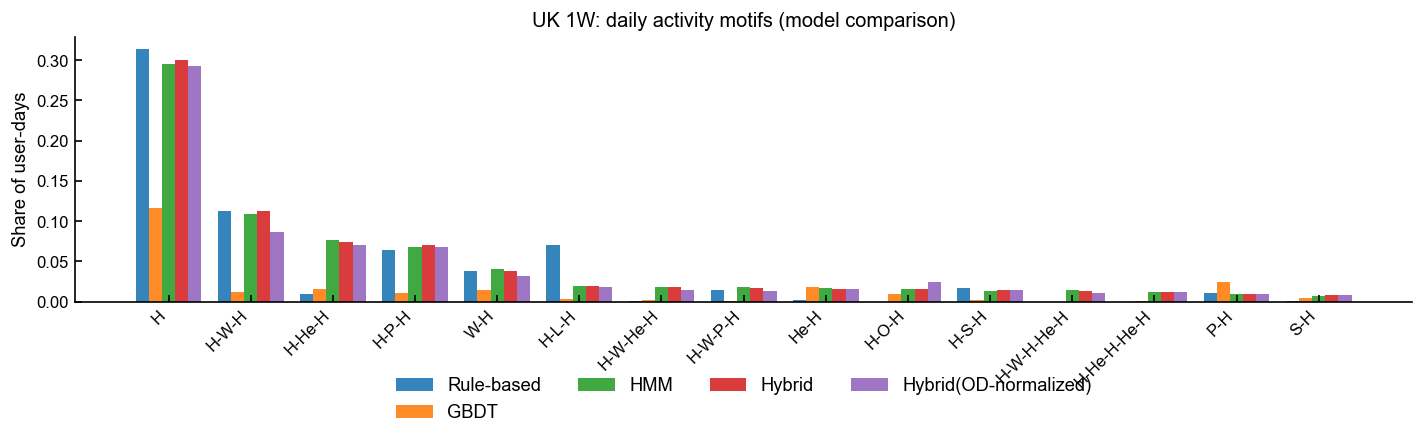

Saved: /Users/pang/Codes/GISRUK/outputs/figures/uk_1w_motifs_models.png
Saved hourly profile tables to: /Users/pang/Codes/GISRUK/outputs/tables


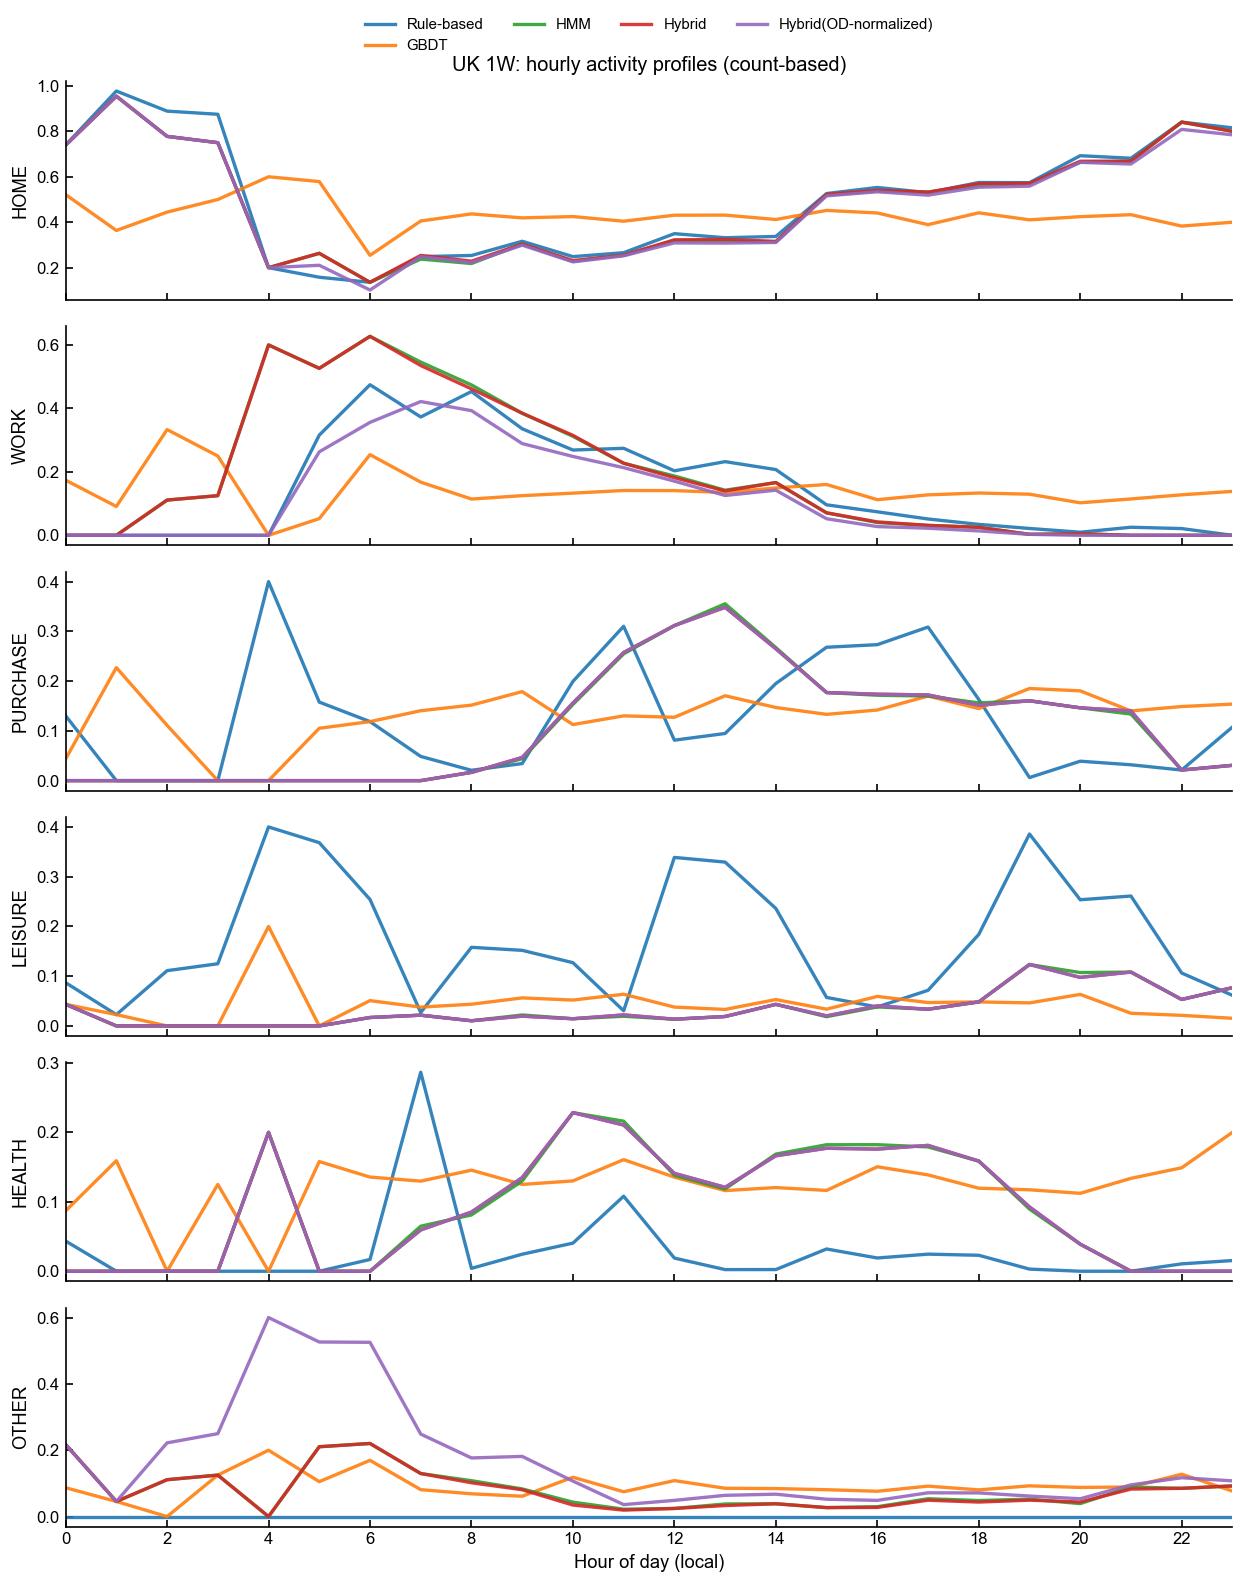

Saved: /Users/pang/Codes/GISRUK/outputs/figures/uk_1w_hourly_profiles_count.png


{'motif_share':              Rule-based      GBDT       HMM    Hybrid  Hybrid(OD-normalized)
 H              0.313603  0.116676  0.294821  0.300512               0.293113
 H-W-H          0.112692  0.011952  0.109277  0.112692               0.087080
 H-He-H         0.009106  0.015367  0.076836  0.073990               0.070575
 H-P-H          0.063745  0.010814  0.067729  0.070575               0.067729
 W-H            0.038702  0.014798  0.040979  0.038702               0.032442
 H-L-H          0.070006  0.003415  0.019920  0.019351               0.018782
 H-W-He-H       0.000569  0.001707  0.018213  0.018213               0.014798
 H-W-P-H        0.014229  0.001138  0.018782  0.017075               0.013660
 He-H           0.002277  0.018782  0.016505  0.015936               0.015367
 H-O-H          0.000000  0.009106  0.015936  0.015367               0.025043
 H-S-H          0.016505  0.001707  0.013660  0.014229               0.014229
 H-W-H-He-H     0.000000  0.000000  0.014229  0.0

In [211]:
export_uk_motifs_hourly("1W")
# export_uk_motifs_hourly("1M")

Saved: /Users/pang/Codes/GISRUK/outputs/tables/uk_1w_motif_share_models.csv


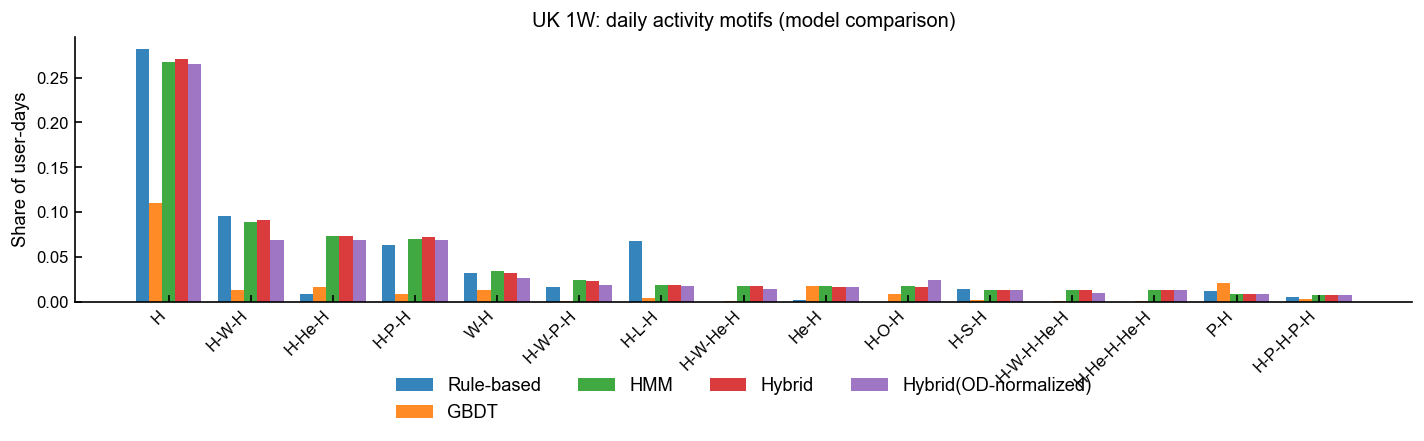

Saved: /Users/pang/Codes/GISRUK/outputs/figures/uk_1w_motifs_models.png
Saved hourly profile tables to: /Users/pang/Codes/GISRUK/outputs/tables


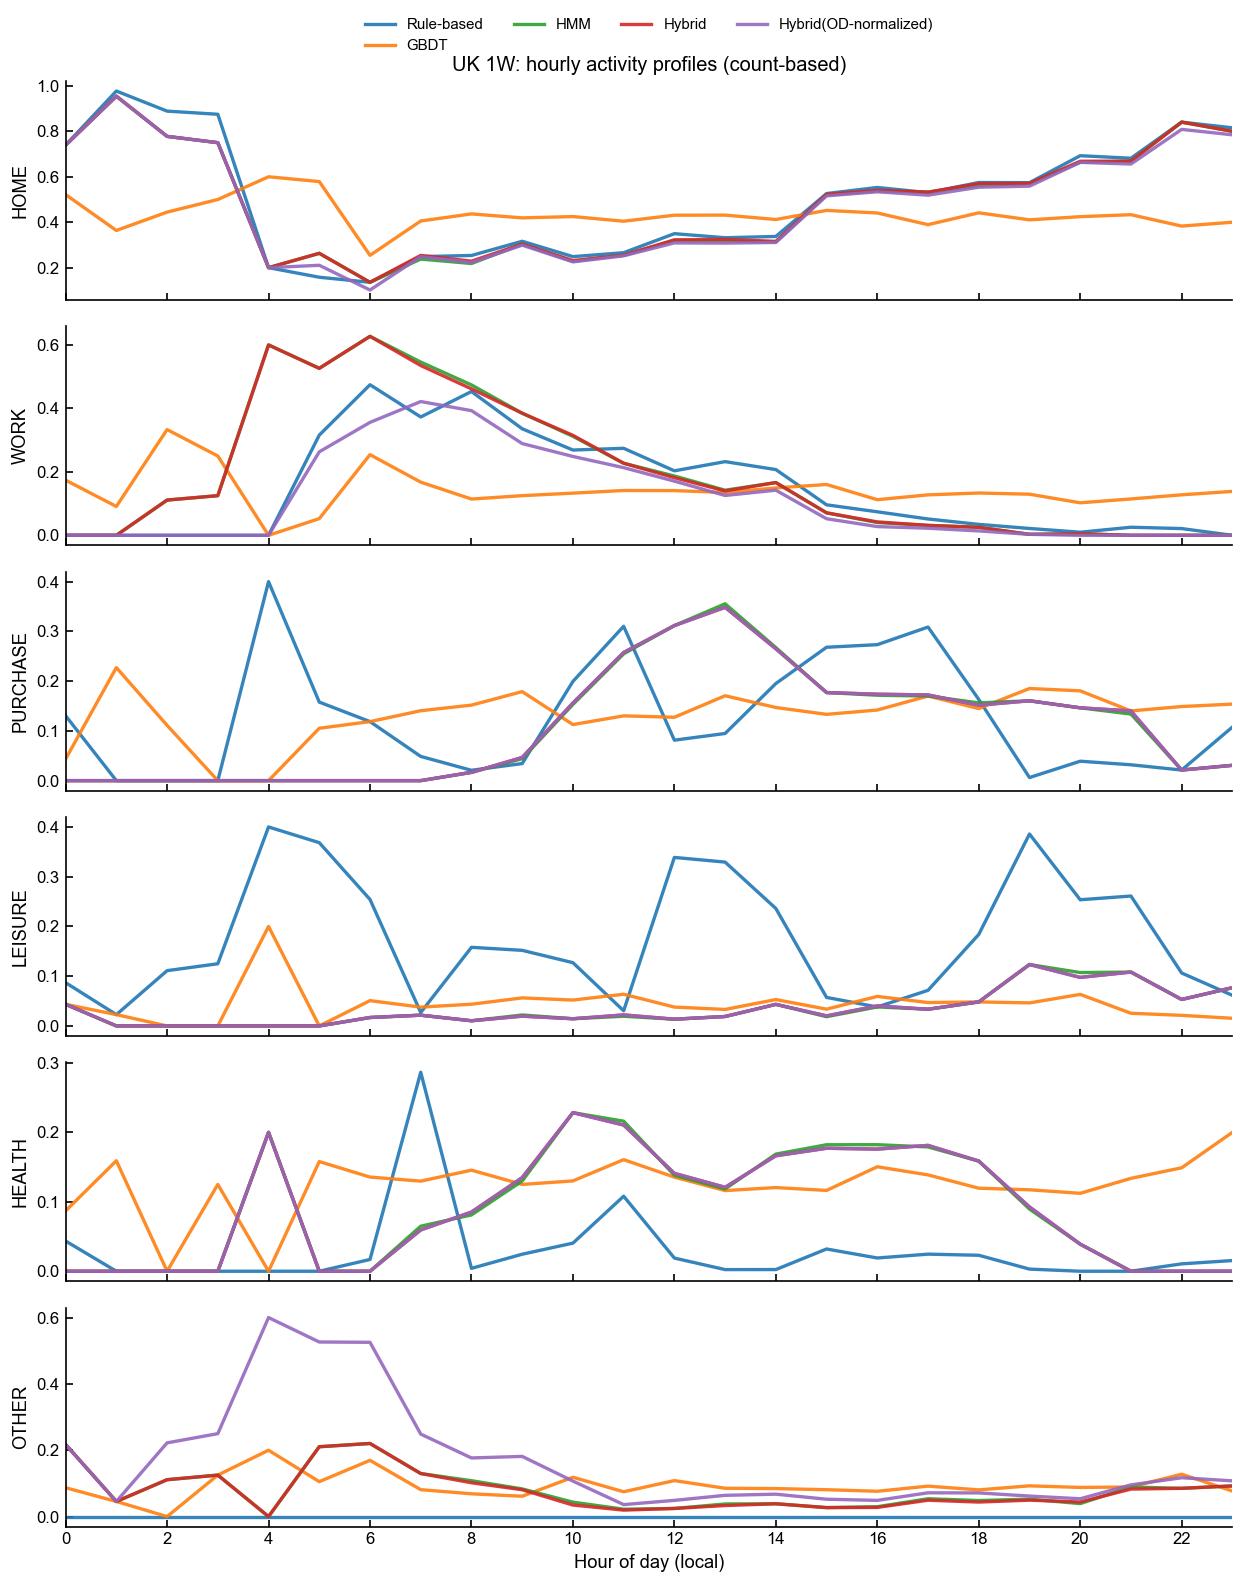

Saved: /Users/pang/Codes/GISRUK/outputs/figures/uk_1w_hourly_profiles_count.png
Saved: /Users/pang/Codes/GISRUK/outputs/tables/uk_1w_motif_share_models.csv


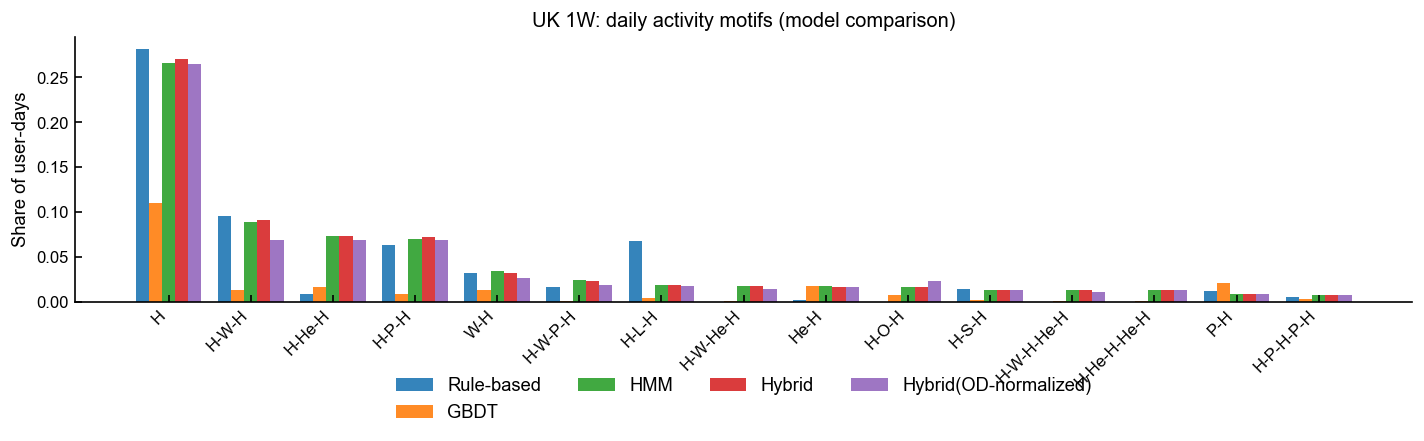

Saved: /Users/pang/Codes/GISRUK/outputs/figures/uk_1w_motifs_models.png
Saved hourly profile tables to: /Users/pang/Codes/GISRUK/outputs/tables


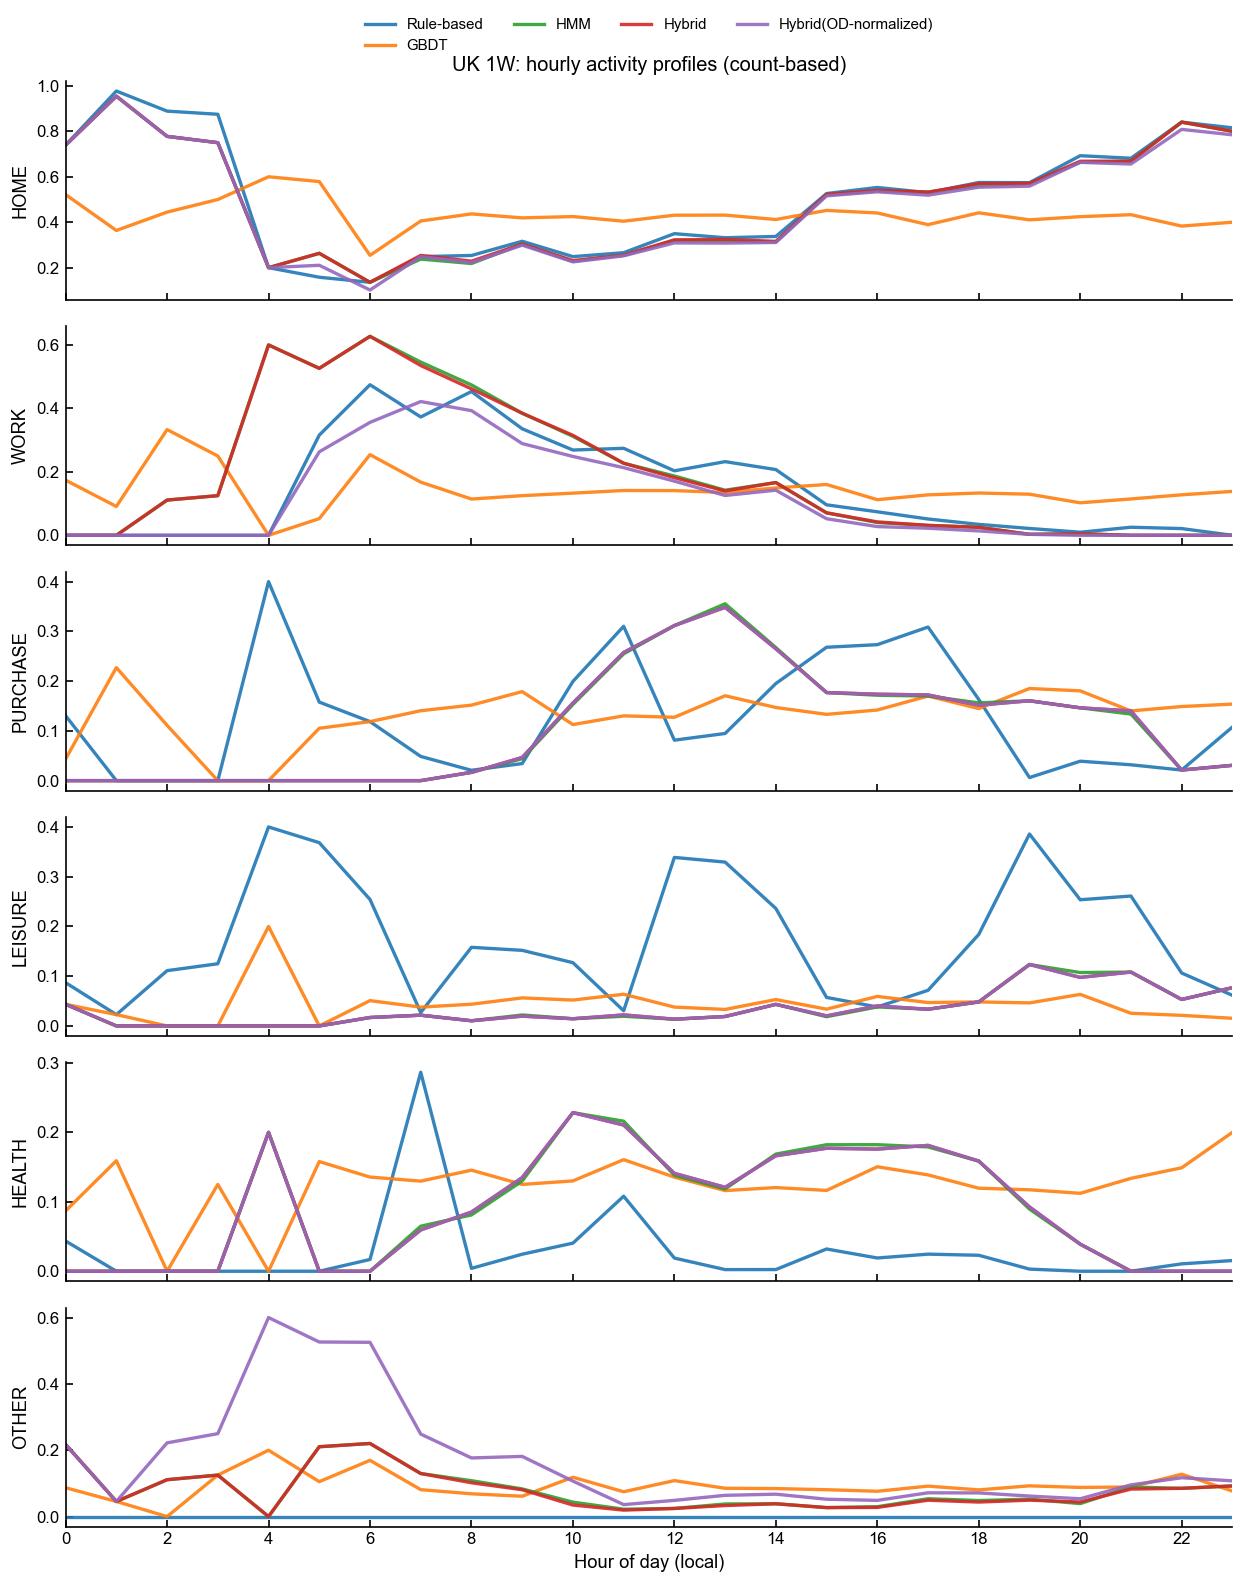

Saved: /Users/pang/Codes/GISRUK/outputs/figures/uk_1w_hourly_profiles_count.png


{'motif_share':              Rule-based      GBDT       HMM    Hybrid  Hybrid(OD-normalized)
 H              0.281161  0.109846  0.266363  0.270347               0.264656
 H-W-H          0.095618  0.013090  0.088788  0.091064               0.068298
 H-He-H         0.008537  0.015936  0.073421  0.072851               0.068867
 H-P-H          0.063176  0.008537  0.069437  0.072282               0.068298
 W-H            0.032442  0.013090  0.034149  0.031873               0.026181
 H-W-P-H        0.016505  0.001138  0.023904  0.022766               0.018213
 H-L-H          0.067160  0.004553  0.018782  0.018213               0.017644
 H-W-He-H       0.000000  0.001138  0.017075  0.017644               0.014229
 He-H           0.001707  0.017075  0.017075  0.016505               0.015936
 H-O-H          0.000000  0.007968  0.016505  0.015936               0.023335
 H-S-H          0.013660  0.002277  0.013090  0.013090               0.013090
 H-W-H-He-H     0.000000  0.000569  0.013090  0.0

In [209]:
export_uk_motifs_hourly("1W", min_dur_min=0, top_k=15)
export_uk_motifs_hourly("1W", min_dur_min=5, top_k=15)

In [212]:
import numpy as np
import pandas as pd
from src.utils_time import to_local_time_series, split_cross_midnight
from src.config import TZ_LONDON

def collapse_consecutive(lst):
    out=[]
    for x in lst:
        if not out or x!=out[-1]:
            out.append(x)
    return out

def compute_commute_proxies(
    df_in: pd.DataFrame,
    label_col: str = "y_pred",
    tz: str = TZ_LONDON,
    assume_utc_if_naive: bool = True,
    work_min_th: float = 240.0,     # 4h
    min_seg_min: float = 10.0,      # ignore tiny segments when determining first/last
):
    """
    Returns a per-(user,date) table with:
      - work_min (sum of WORK minutes)
      - has_home (any HOME segment that day)
      - first_label / last_label (after filtering min_seg_min + collapsing)
      - workday (weekday & work_min>=work_min_th)
      - commute_like_strict (workday & first==HOME & last==HOME)
    """
    d = df_in.copy()
    d["user_id"] = d["user_id"].astype(str)
    d["start_time"] = pd.to_datetime(d["start_time"])
    d["end_time"] = pd.to_datetime(d["end_time"])
    d["duration_min"] = pd.to_numeric(d["duration_min"], errors="coerce")
    d = d.dropna(subset=["user_id","start_time","end_time","duration_min",label_col]).copy()

    # localize
    d["start_time"] = to_local_time_series(d["start_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)
    d["end_time"]   = to_local_time_series(d["end_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)

    # split cross-midnight
    d = split_cross_midnight(d)
    d["date"] = d["start_time"].dt.date
    d["dow"] = d["start_time"].dt.weekday
    d["is_weekday"] = (d["dow"] < 5)

    # aggregate work minutes
    work = d[d[label_col].astype(str)=="WORK"].groupby(["user_id","date"], as_index=False)["duration_min"].sum()
    work = work.rename(columns={"duration_min":"work_min"})

    # has HOME that day
    has_home = d[d[label_col].astype(str)=="HOME"].groupby(["user_id","date"]).size().rename("has_home").reset_index()
    has_home["has_home"] = True

    # first/last label after filtering tiny segments
    d2 = d[d["duration_min"] >= float(min_seg_min)].copy().sort_values(["user_id","date","start_time"])

    first_last_rows = []
    for (u, date), g in d2.groupby(["user_id","date"], sort=False):
        labs = g[label_col].astype(str).tolist()
        labs = collapse_consecutive(labs)
        if len(labs)==0:
            continue
        first_last_rows.append((u, date, labs[0], labs[-1]))
    first_last = pd.DataFrame(first_last_rows, columns=["user_id","date","first_label","last_label"])

    # merge
    base = d[["user_id","date","dow","is_weekday"]].drop_duplicates()
    out = base.merge(work, on=["user_id","date"], how="left") \
              .merge(has_home, on=["user_id","date"], how="left") \
              .merge(first_last, on=["user_id","date"], how="left")

    out["work_min"] = out["work_min"].fillna(0.0)
    out["has_home"] = out["has_home"].fillna(False)

    out["workday"] = out["is_weekday"] & (out["work_min"] >= work_min_th)
    out["commute_like_strict"] = out["workday"] & (out["first_label"]=="HOME") & (out["last_label"]=="HOME")

    # relaxed version (optional): just require some HOME present that day
    out["commute_like_relaxed"] = out["workday"] & (out["has_home"])

    return out

def summarize_models_commute(uk_dict, label_col="y_pred", work_min_th=240, min_seg_min=10):
    rows=[]
    for name, dfm in uk_dict.items():
        daily = compute_commute_proxies(
            dfm, label_col=label_col, work_min_th=work_min_th, min_seg_min=min_seg_min
        )
        # restrict to weekdays only for rates
        wk = daily[daily["is_weekday"]].copy()
        denom = len(wk)
        if denom == 0:
            rows.append({"model": name, "weekday_days": 0, "workday_rate": np.nan,
                         "commute_like_strict_rate": np.nan, "commute_like_relaxed_rate": np.nan,
                         "mean_work_min_weekday": np.nan})
            continue

        rows.append({
            "model": name,
            "weekday_days": denom,
            "workday_rate": float(wk["workday"].mean()),
            "commute_like_strict_rate": float(wk["commute_like_strict"].mean()),
            "commute_like_relaxed_rate": float(wk["commute_like_relaxed"].mean()),
            "mean_work_min_weekday": float(wk["work_min"].mean()),
        })
    return pd.DataFrame(rows).sort_values("workday_rate", ascending=False)

summary_commute = summarize_models_commute(uk, work_min_th=240, min_seg_min=10)
summary_commute

,model,weekday_days,workday_rate,commute_like_strict_rate,commute_like_relaxed_rate,mean_work_min_weekday
2,HMM,1324,0.270393,0.180514,0.262840,135.712097
3,Hybrid,1324,0.262840,0.179003,0.257553,130.633220
0,Rule-based,1324,0.257553,0.179758,0.254532,131.016553
1,GBDT,1324,0.198640,0.009819,0.151057,124.366616


In [219]:
# per model: distribution of weekday work_min (quantiles)
for name, dfm in uk.items():
    daily = compute_commute_proxies(dfm, work_min_th=240, min_seg_min=10)
    wk = daily[daily["is_weekday"]]
    print("\n", name)
    print(wk["work_min"].describe()[["count","mean","50%","75%","max"]])


 Rule-based
count    1324.000000
mean      131.016553
50%         0.000000
75%       250.329167
max      3520.683333
Name: work_min, dtype: float64

 GBDT
count    1324.000000
mean      124.366616
50%         0.000000
75%       100.129167
max      2528.266667
Name: work_min, dtype: float64

 HMM
count    1324.000000
mean      135.712097
50%         0.000000
75%       275.716667
max      1425.583333
Name: work_min, dtype: float64

 Hybrid
count    1324.000000
mean      130.633220
50%         0.000000
75%       259.520833
max       970.033333
Name: work_min, dtype: float64
